In [1]:
import os
import multiprocessing
from multiprocessing.pool import ThreadPool
import copy

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgbm
from catboost import CatBoostRegressor as cat
from sklearn.metrics import r2_score

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA
import glob

C:\Users\remig\Anaconda3\lib\site-packages\backtesting\_plotting.py:37: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `bokeh.io.reset_output()`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
class SmaCross(Strategy): 
    n1 = 5 
    n2 = 15

    def init(self):
        self.sma1 = self.I(SMA, self.data.PM10, self.n1)
        self.sma2 = self.I(SMA, self.data.PM10, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()

class SmaCross(Strategy):

    def init(self):
        print(self.data)
        # 한줄씩 호출되는듯
        #self.data = data
        self.close = self.data['Close']
        self.time_shifted_price = self.data['time shifted']
        self.daycount = 0
        self.hold = False

    def next(self):
        if (self.close < self.time_shifted_price) and (self.hold == False) :
            self.buy()
            self.hold = True
            self.daycount = 0
        
        elif (self.close >= self.time_shifted_price) and (self.hold == True):
            self.sell()
            self.hold = False
            
        
        elif (self.daycount > 2):
            self.sell()
            self.hold=False
       


        self.daycount += 1
        
# daycount 는 무조건 +1 해야하고, 팔고 나서도 다시 생각해봐야하고
# else에 daycount 가 들어가 있는 것이 잘못되었을 가능성이 있다.

In [29]:
files = glob.glob('C:\\Users\\remig\\Desktop\\stock\\*')
df3 = pd.DataFrame(columns=[])
list_col = []
for i in tqdm(range(len(files))):
    list_col.append(files[i].split("\\")[5])

100%|██████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<?, ?it/s]


In [30]:

plt.rc('font',family='NanumGothic')


def auto(m):
    global files
    global df3
    global list_col
    
    df_input   = pd.read_pickle('C:\\Users\\remig\\Desktop\\findust1.pkl')
    stock_data = pd.read_csv(files[m])
    stock_data = stock_data.rename(columns={stock_data.columns[0]:'측정일시'})
    stock_data = stock_data.drop(['Adj Close'],axis=1)
    
    index_list = []

    for i in tqdm(range(len(df_input))):
        index_list.append(datetime.datetime(int(df_input.index[i][0:4]),int(df_input.index[i][4:6]),int(df_input.index[i][6:8])))

    df_input.index = index_list
    
    index_list = []
    for i in tqdm(range(len(stock_data))):
        index_list.append(datetime.datetime(int(str(stock_data['측정일시'][i])[0:4]),
                                        int(str(stock_data['측정일시'][i])[4:6]),int(str(stock_data['측정일시'][i])[6:8])))
    
    stock_data['측정일시'] = index_list
    stock_data.index = stock_data['측정일시']
    
    stock_data = stock_data.drop(['측정일시'],axis=1)
    
    stock_close = stock_data['Close']
    df_input    = df_input['PM10']
    others = stock_data[['Open', 'Close', 'High', 'Low', 'Volume']]
    
    df_input
    df = stock_data.merge(df_input, how='inner', left_on=stock_data.index, right_on=df_input.index)
    df = df.drop([df.index[0]],axis=0)
    
    # hyperparameter
    
    time_shift = -1
    
    df_original = copy.deepcopy(df)
    df.index = df['key_0']

    df = df.drop(['key_0'], axis=1)
    
    # process 


    # target y (Future data)
    df['y'] = df['Close'].shift(time_shift)
    df = df[df['y'].notnull()]


    df = df[df.index <= df.index[-1]]
    #datetime.datetime(2018,12,31)

    # split train/test
    y = df['y']
    x = df.drop(['y','Open', 'High', 'Low'],axis=1)
    others = df[['Open', 'Close', 'High', 'Low', 'Volume']]
    x_columns = x.columns
    
    x_train = x[x.index < datetime.datetime(2018,10,1)].values  #425: 2018.10.01
    x_valid = x[x.index >= datetime.datetime(2018,10,1)].values
    y_train = y[y.index < datetime.datetime(2018,10,1)].values
    y_valid = y[y.index >= datetime.datetime(2018,10,1)].values
    others_train = others[others.index < datetime.datetime(2018,10,1)]
    others_valid = others[others.index >= datetime.datetime(2018,10,1)]

    print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)
    
    # numt
    
    num_threads = 10
    
    # model

    model = lgbm(num_threads=num_threads)
    #model = xgb(nthread=num_threads)
    #model = cat(thread_count=num_threads, verbose=0)
    # 위 두개로도 가능

    model.fit(x_train, y_train)

    y_train_hat = model.predict(x_train)
    y_valid_hat = model.predict(x_valid)

    print(r2_score(y_train, y_train_hat), r2_score(y_valid, y_valid_hat))

    plt.figure(figsize=(20, 5))
    plt.plot(df.index, df['Close'], label='close')
    #plt.plot(df.index, pd.concat([pd.Series(y_train), pd.Series(y_valid)], ignore_index=True), label='%s after (close)' % (-time_shift))
    plt.plot(df.index, pd.concat([pd.Series(y_train_hat), pd.Series(y_valid_hat)], ignore_index=True), 
         label='%s after (predicted)' % (-time_shift), alpha=0.6)
    plt.axvspan(df.index[0], df.index[len(y_train)], alpha=0.2, color='yellow', label='train')

    plt.legend()
    plt.show()
    
    ## bt.run
    
    data = pd.DataFrame(x_valid, columns=x_columns)
    data = data.merge(others_valid, how='inner')
    data['Volume'] = data['Volume'].astype(float)
    data['Close'] = data['Close'].astype(float)
    data['PM10'] = pd.to_numeric(data['PM10'])
    data1 = data.drop(['Open', 'High','Low'], axis=1)


    yhat = model.predict(data1)
    data['time shifted'] = yhat
    
    
    # Backtesting
    
    bt = Backtest(data, SmaCross, cash=10000, commission=0)
    
    
    # 저장
    a = bt.run()
    df3[files[m].split('\\')[5]] = a


100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 14824.28it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9921549763080404 0.7853485550965529


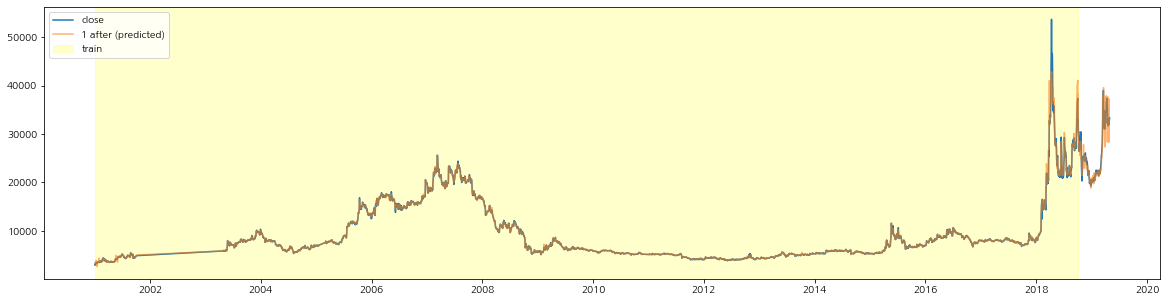

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.


In [31]:
auto(1)

100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 137603.34it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4714/4714 [00:00<00:00, 14025.49it/s]


(3942, 3) (142, 3) (3942,) (142,)
0.9984070598472007 0.8878658499841535


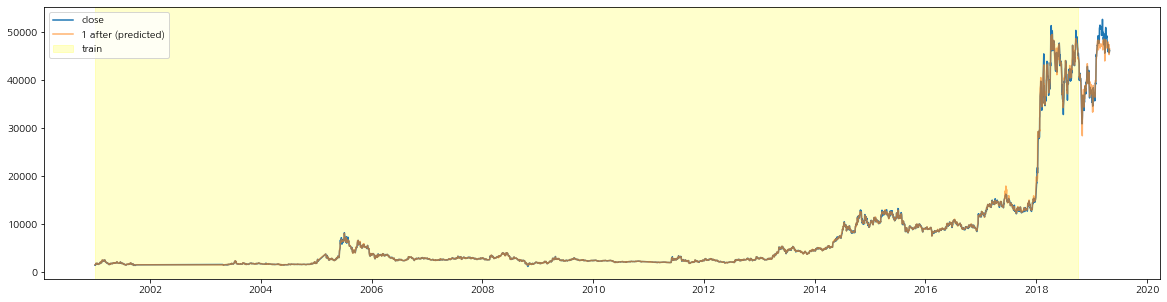

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 126014.24it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 12320.04it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9921549763080404 0.7853485550965529


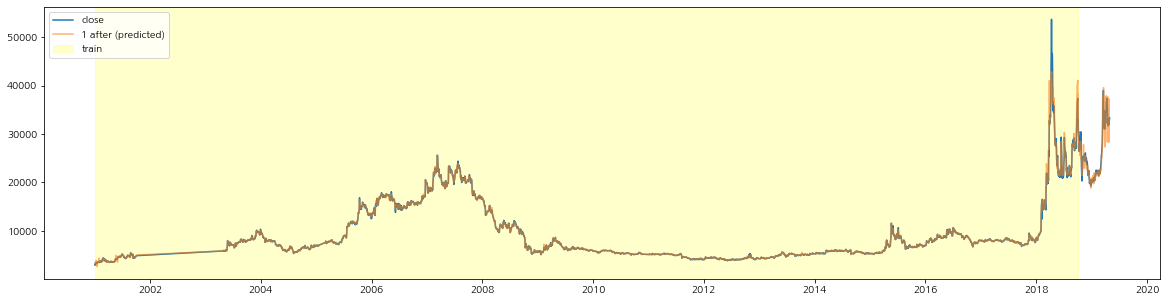

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 128817.87it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 11702.13it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9985535958873417 0.8841466954802271


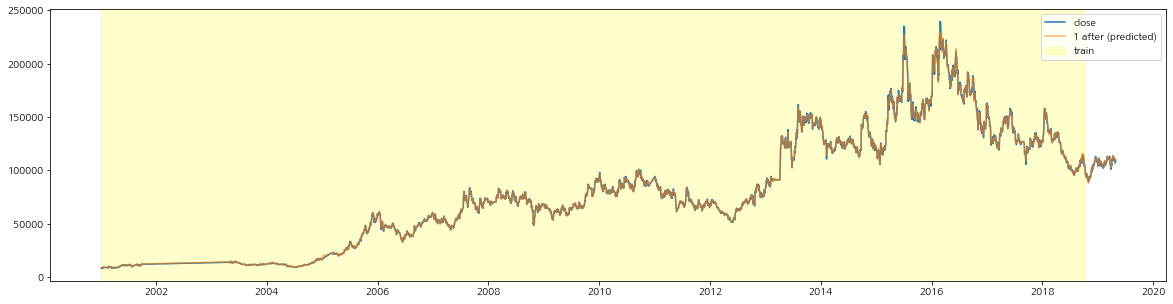

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|███████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 73830.33it/s]

100%|████████████████████████████████████████████████████████████████████████████| 7785/7785 [00:01<00:00, 6766.87it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9975207128763987 0.8838327901699983


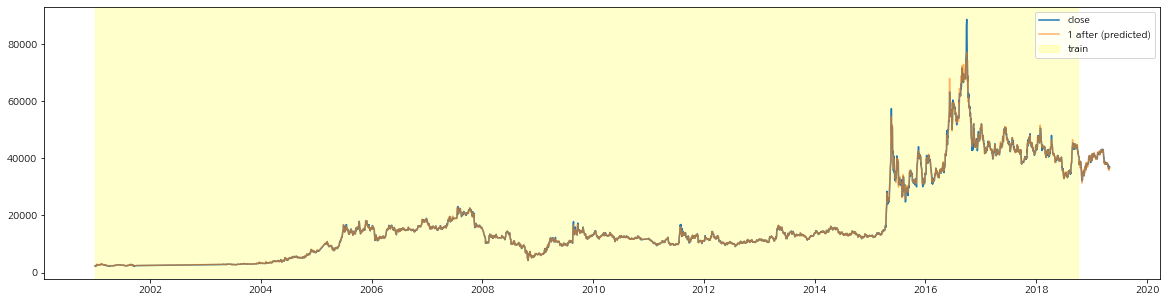

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 201789.66it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4787/4787 [00:00<00:00, 17841.63it/s]


(3942, 3) (142, 3) (3942,) (142,)
0.9978527569739815 0.9202464306520544


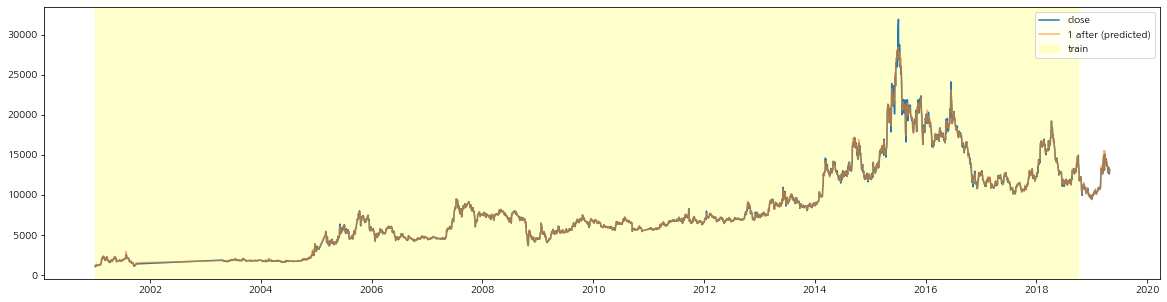

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 183450.86it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 21532.37it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9980452428395193 0.01148314292905217


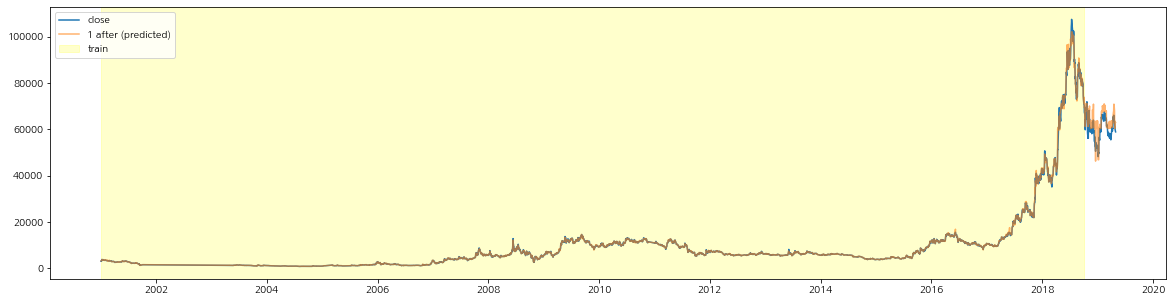

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 183465.48it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 20982.17it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9963765175110482 0.9786012294336172


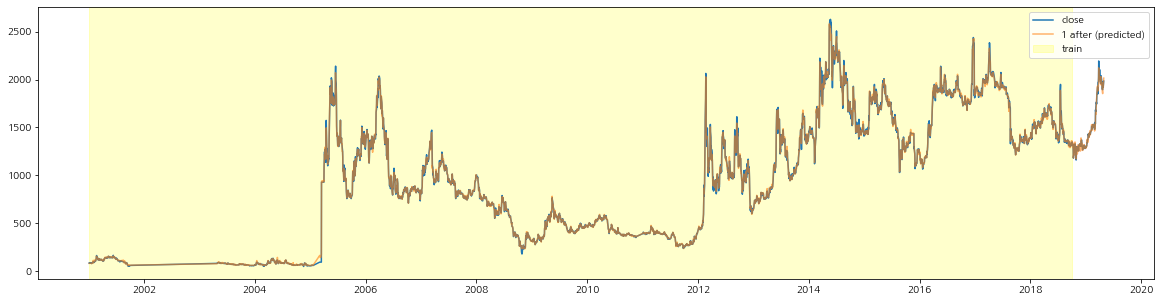

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 172963.94it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 16821.66it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9961190254827759 0.8212397834753268


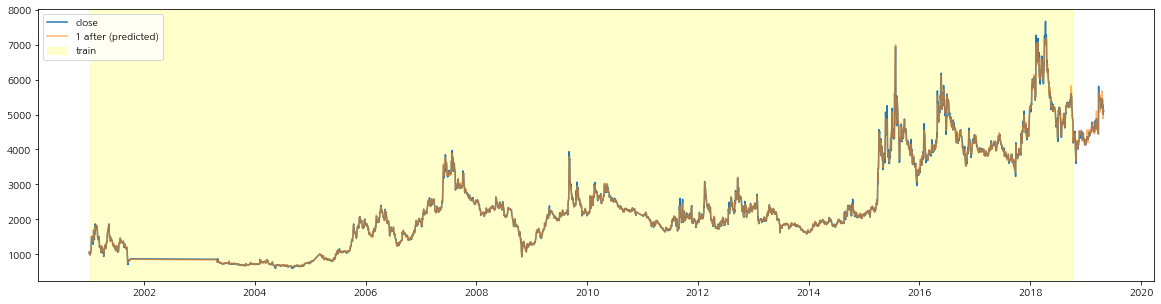

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 208760.94it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 17859.61it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9991482427672923 0.9075786799967918


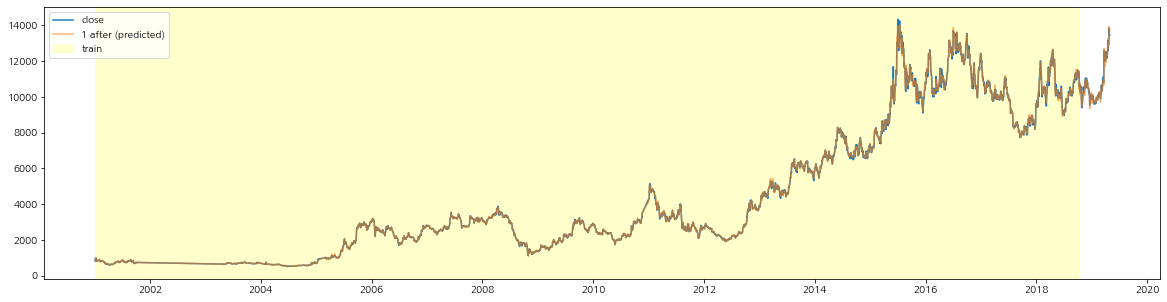

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 189194.58it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 22955.72it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9977684542223977 0.8761944691816876


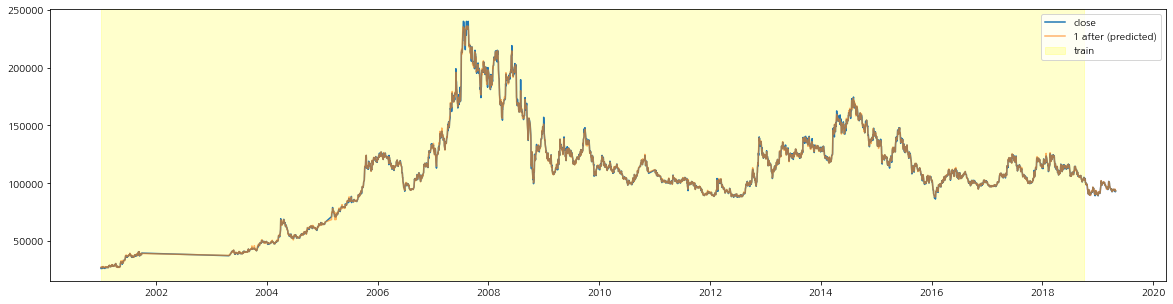

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 151359.73it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 18027.26it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9977061914427793 0.37128997550674536


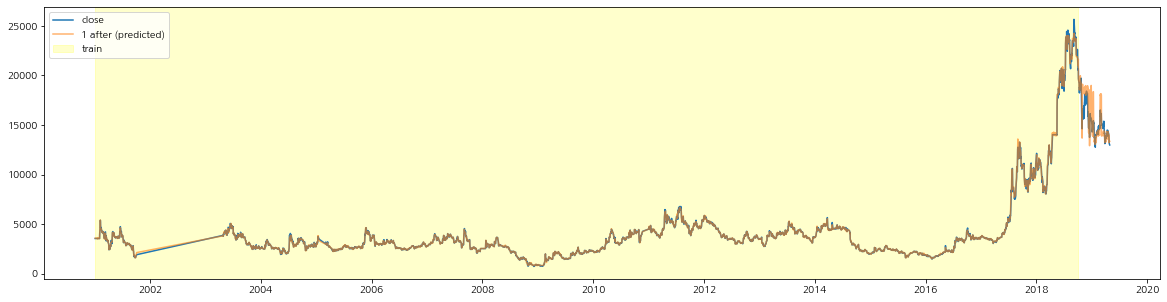

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 168162.07it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 20982.57it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9963276261055865 0.7712183159229674


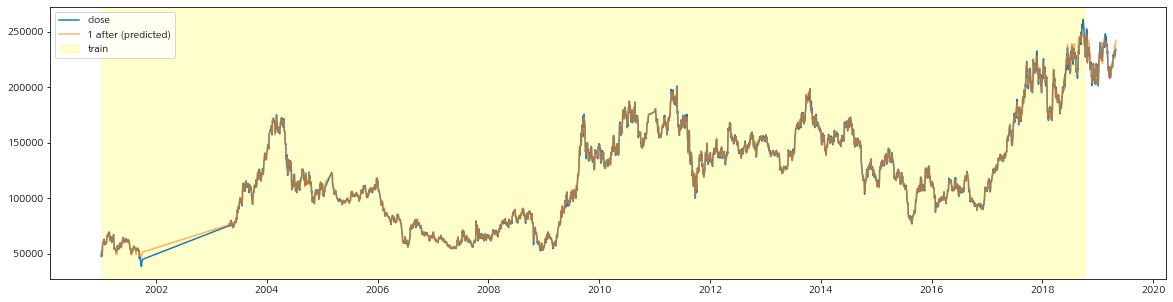

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 195294.52it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 18086.61it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.988820764049734 0.8654353353132231


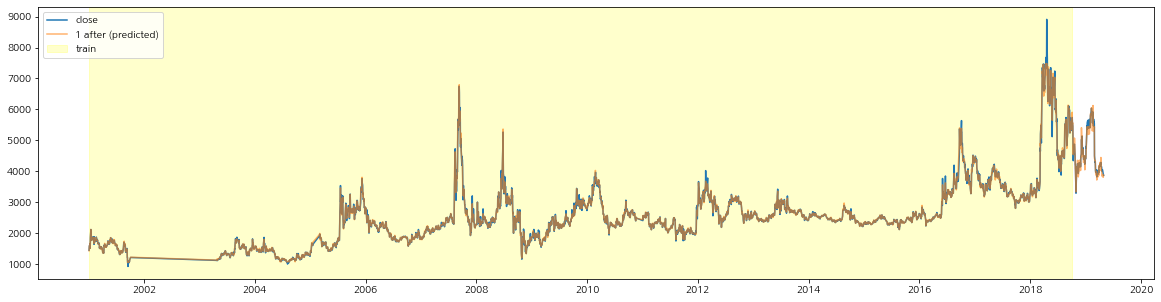

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 140799.63it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5878/5878 [00:00<00:00, 14270.67it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9958714165649647 0.8003680905779962


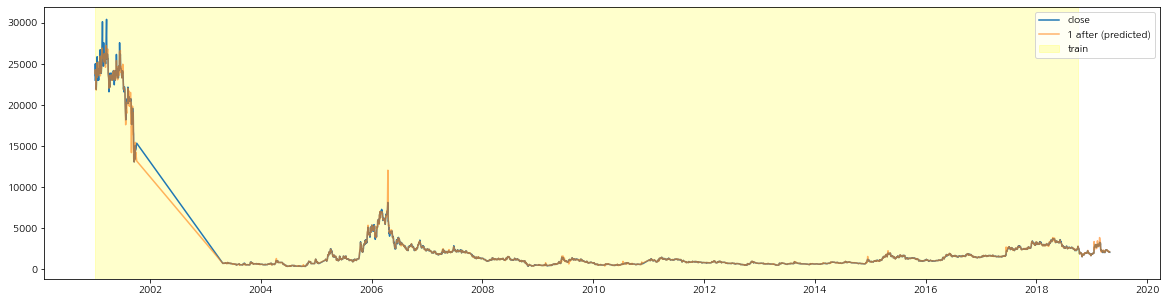

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|███████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 96092.98it/s]

100%|███████████████████████████████████████████████████████████████████████████| 6362/6362 [00:00<00:00, 12034.77it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.996954230343203 0.9733930655460243


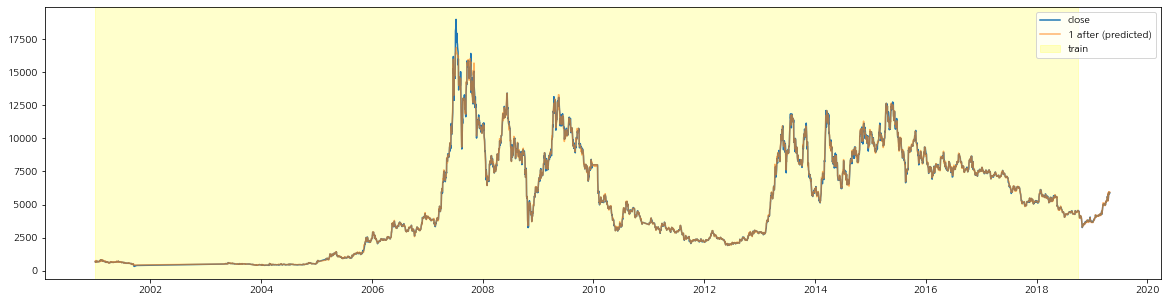

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 131528.09it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5478/5478 [00:00<00:00, 13712.32it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9987865542515845 0.902010550568155


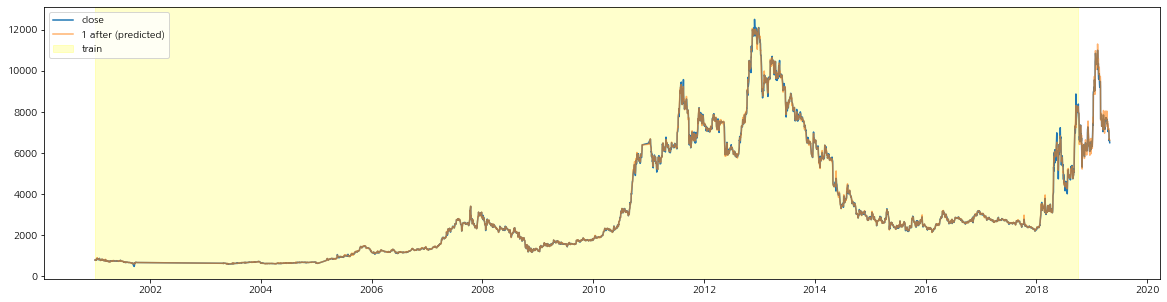

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 121011.12it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 13106.67it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9967069845346141 -0.20559578218874153


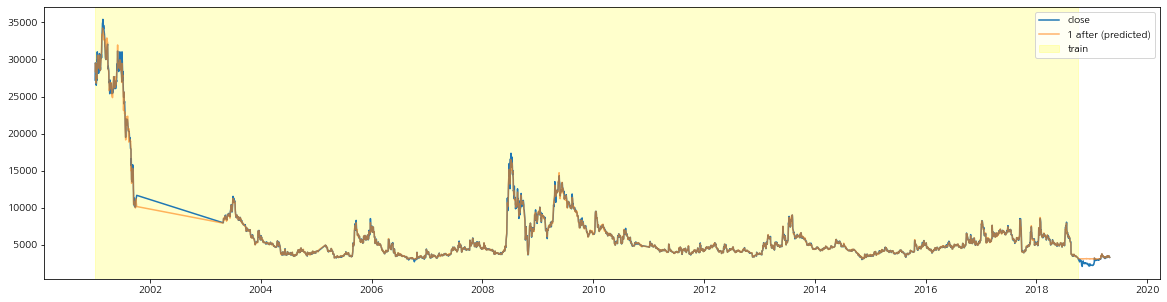

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 110078.97it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5877/5877 [00:00<00:00, 15506.58it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9971187141265878 0.6661192989220106


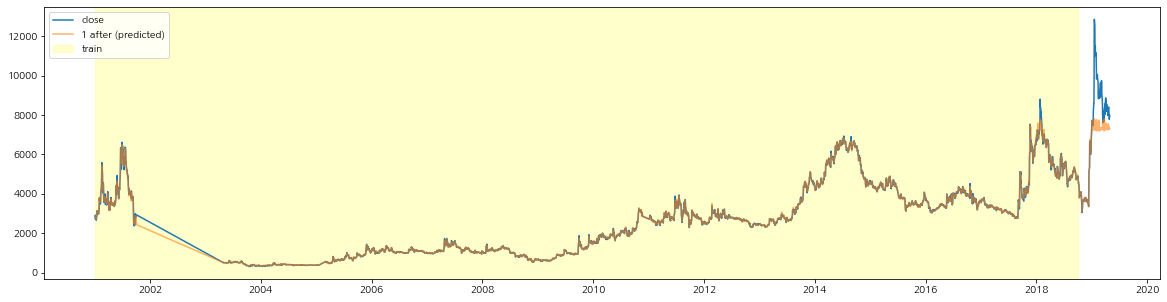

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 144115.95it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5698/5698 [00:00<00:00, 12181.71it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.990755807350339 0.8916855040017863


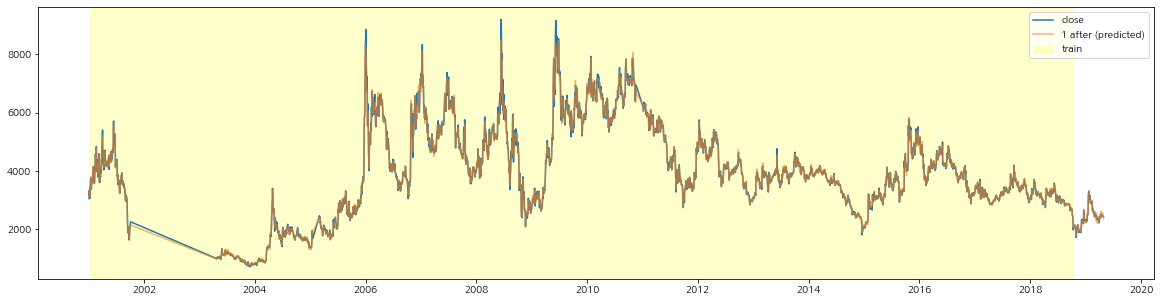

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 114233.94it/s]

100%|███████████████████████████████████████████████████████████████████████████| 7785/7785 [00:00<00:00, 15010.16it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9956759194048029 0.9174562309574719


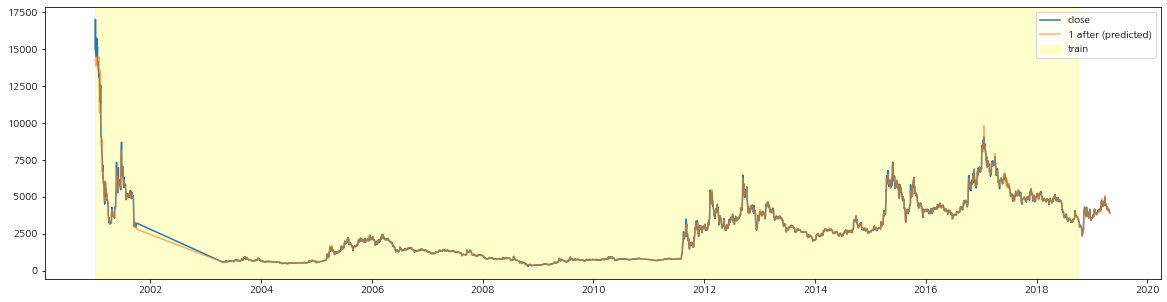

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 131502.82it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5877/5877 [00:00<00:00, 14916.21it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9893304615129597 0.9555356766781559


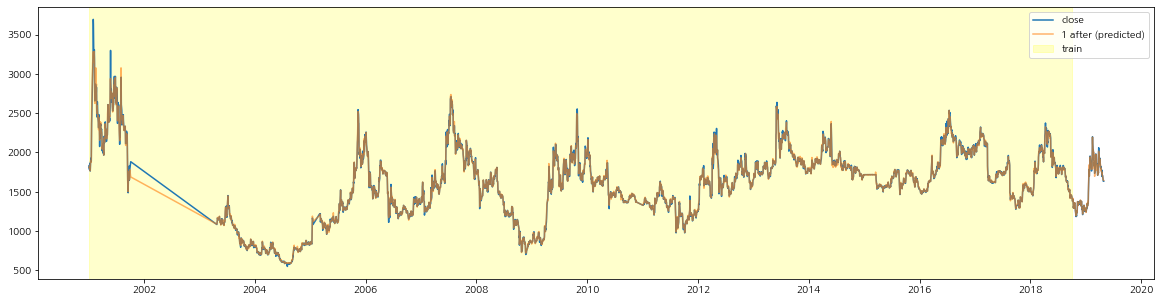

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 126130.97it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2136/2136 [00:00<00:00, 14516.29it/s]


(1866, 3) (142, 3) (1866,) (142,)
0.9981611629516808 0.8364061890073294


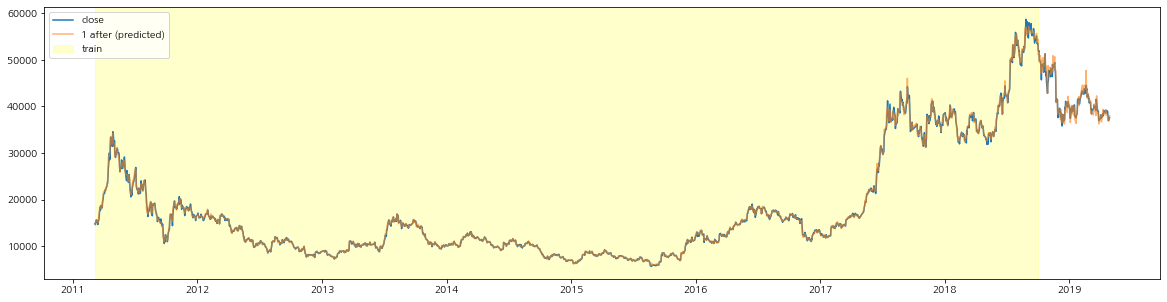

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 128753.04it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5331/5331 [00:00<00:00, 13464.16it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9991089610456936 0.9139738541873043


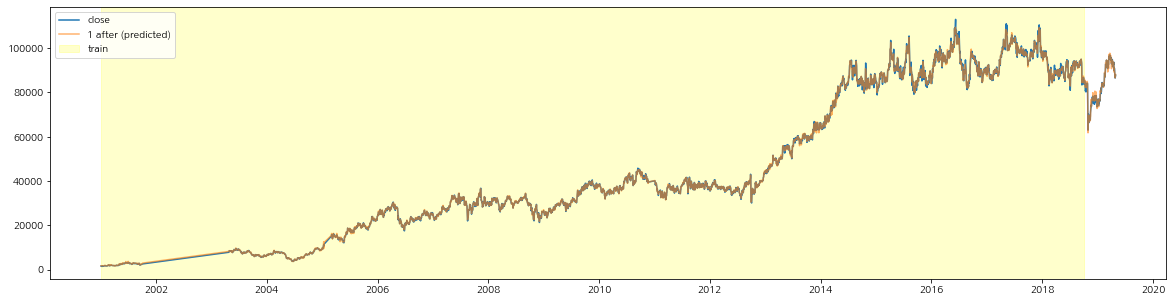

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|███████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 40906.56it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4676/4676 [00:00<00:00, 16222.15it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9958390514569804 0.8996268316889078


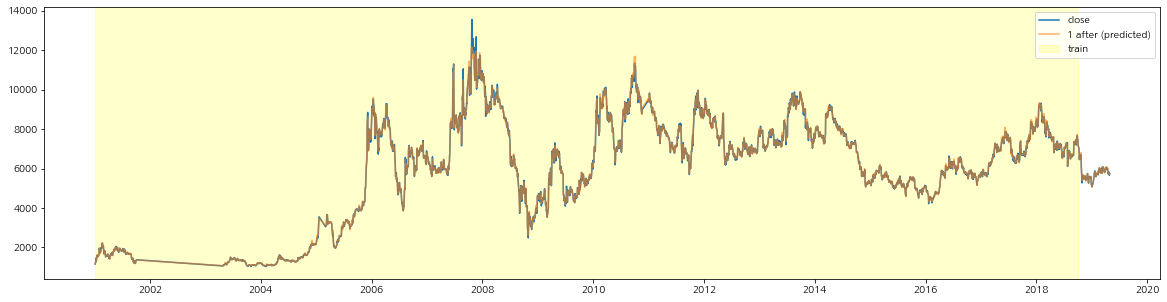

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 159322.12it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5571/5571 [00:00<00:00, 15137.12it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9967644210369443 0.9189612719302207


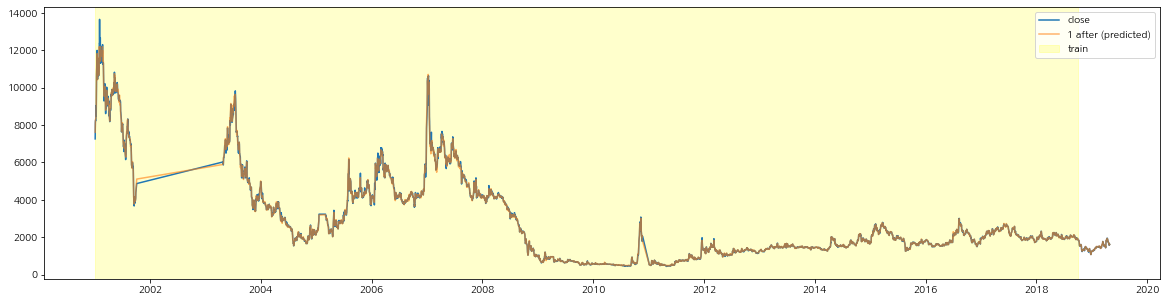

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 183464.15it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5445/5445 [00:00<00:00, 20998.13it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9966602961625407 0.8120250918622967


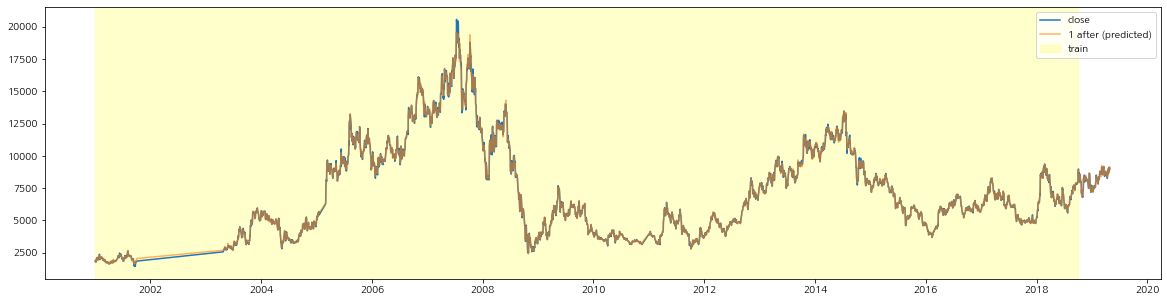

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 178110.72it/s]

100%|███████████████████████████████████████████████████████████████████████████| 5331/5331 [00:00<00:00, 24129.65it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9981361245357437 0.9527396319813339


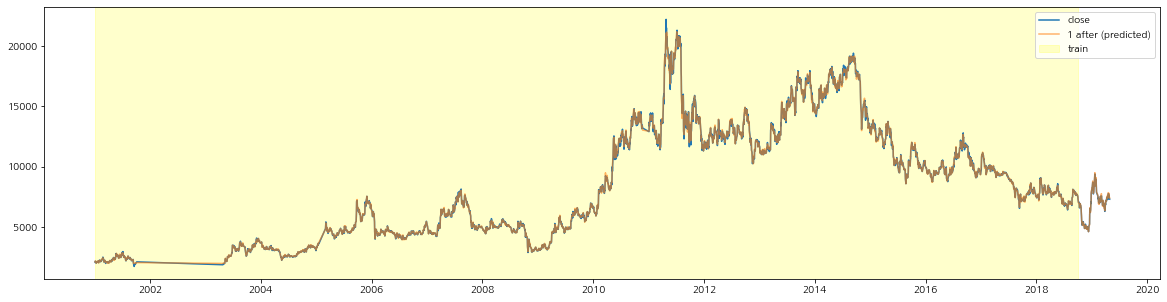

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 192179.39it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4700/4700 [00:00<00:00, 19819.36it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.997618833467328 0.9594785368732379


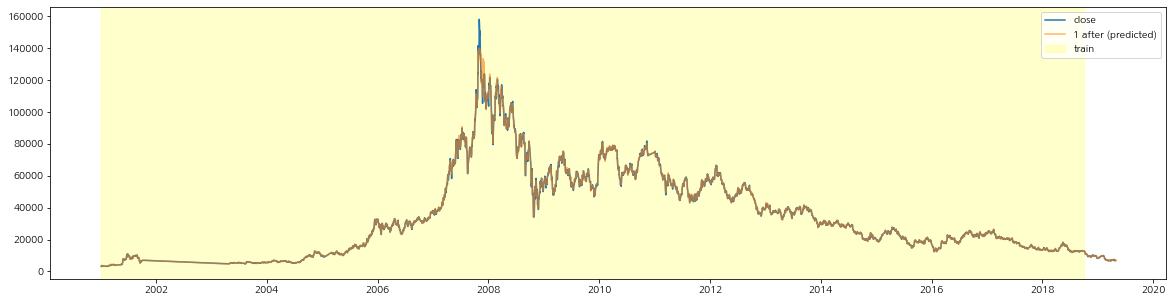

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 195288.50it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4993/4993 [00:00<00:00, 22851.42it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.99266256452681 0.7246739063415111


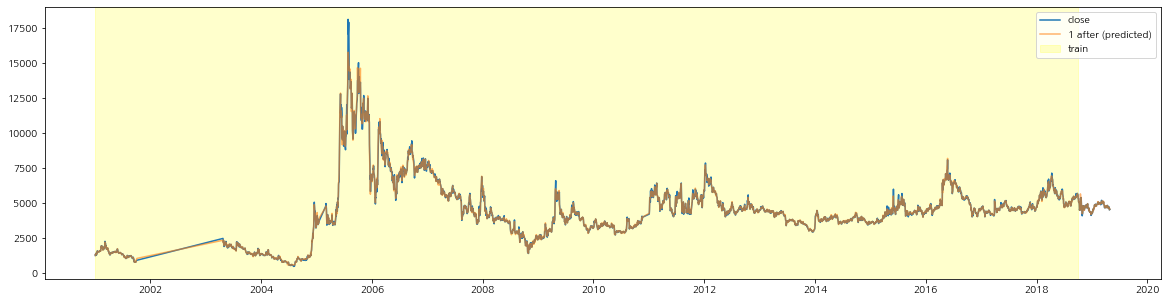

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 168168.77it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4907/4907 [00:00<00:00, 21207.36it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9964496318511925 0.9079217711216448


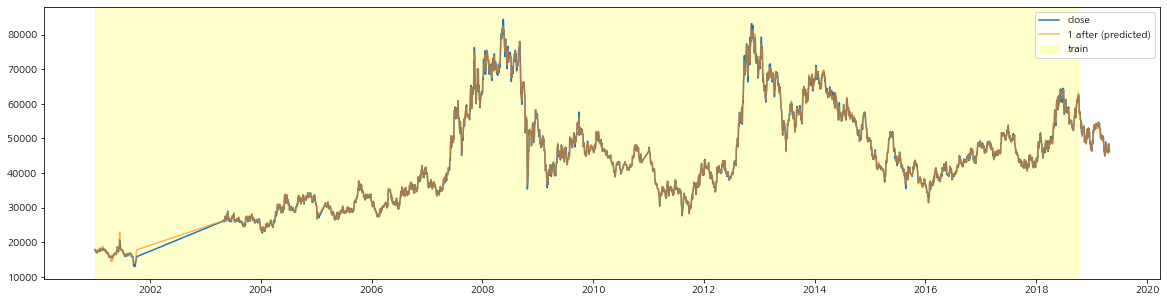

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 201826.65it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4887/4887 [00:00<00:00, 21809.14it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9985125998195873 0.7535041456636711


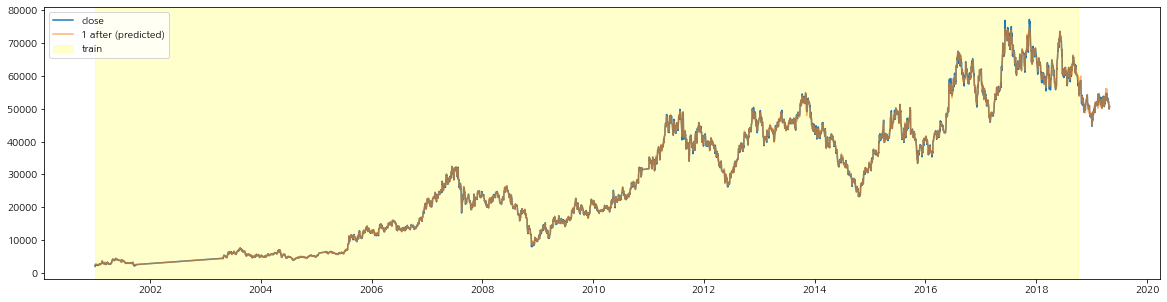

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 118667.60it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4163/4163 [00:00<00:00, 19595.88it/s]


(3757, 3) (142, 3) (3757,) (142,)
0.9934691172346702 0.8567381492394699


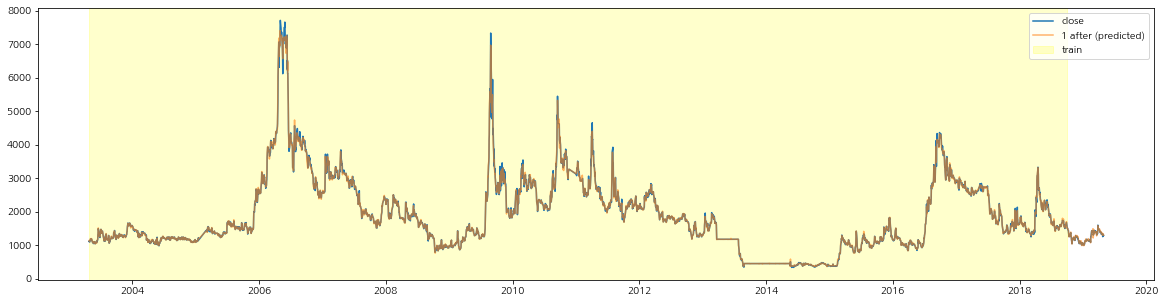

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 208647.43it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4751/4751 [00:00<00:00, 18533.94it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9902604287565918 0.6308312614014757


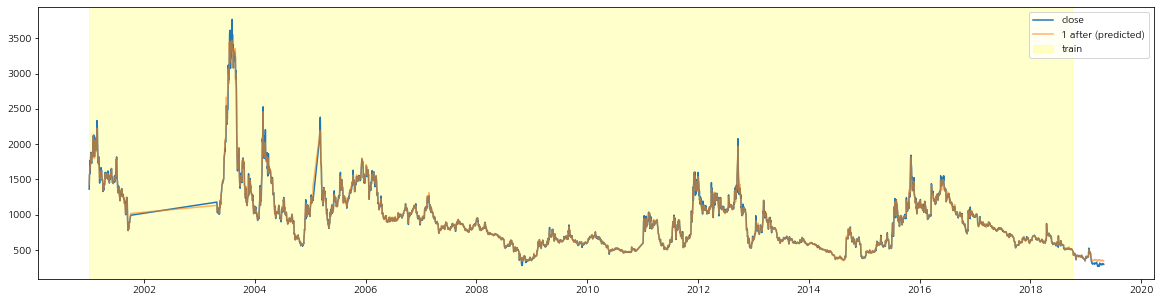

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 216216.37it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4431/4431 [00:00<00:00, 21257.50it/s]


(3757, 3) (142, 3) (3757,) (142,)
0.9886013671832722 0.8714604769669269


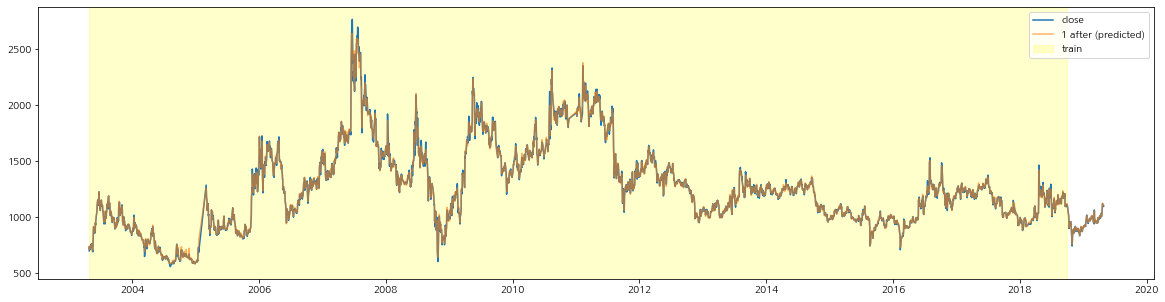

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 151365.16it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4701/4701 [00:00<00:00, 19436.22it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.998020383996212 0.9002660309046125


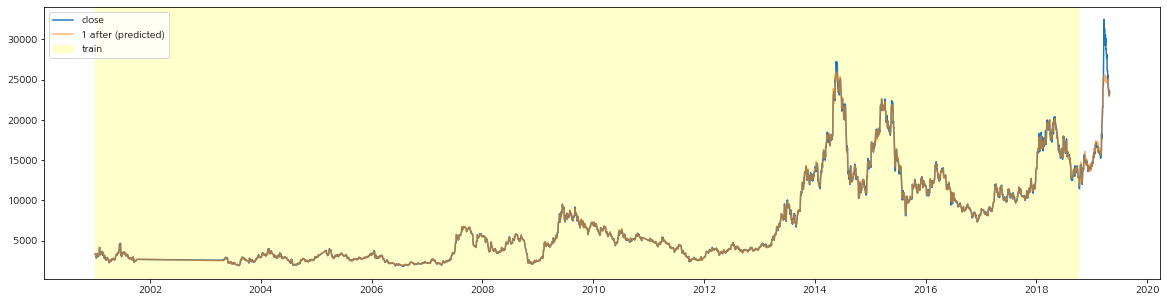

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 178049.37it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4749/4749 [00:00<00:00, 23926.83it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9976398104576129 0.8194083913503595


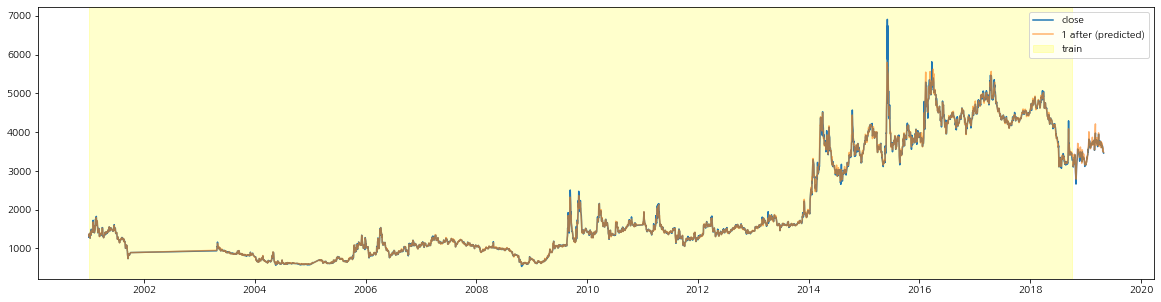

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 216218.22it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4671/4671 [00:00<00:00, 22091.81it/s]


(3943, 3) (142, 3) (3943,) (142,)
0.9976295336516955 0.4374588332219981


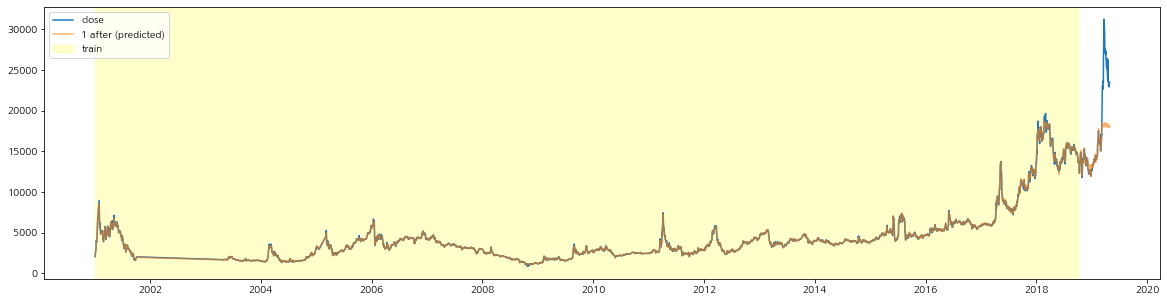

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 201699.66it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4580/4580 [00:00<00:00, 21655.95it/s]


(3867, 3) (142, 3) (3867,) (142,)
0.9985097444866373 0.8425159391984908


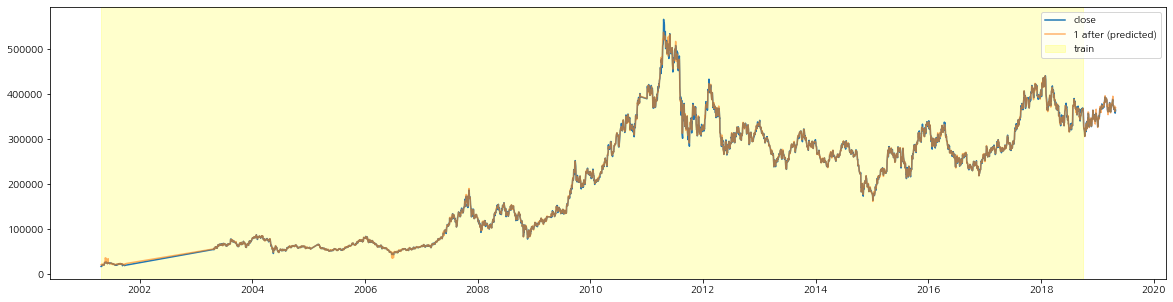

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 208776.43it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2439/2439 [00:00<00:00, 24815.30it/s]


(2141, 3) (142, 3) (2141,) (142,)
0.9973596730606484 0.9467580533591121


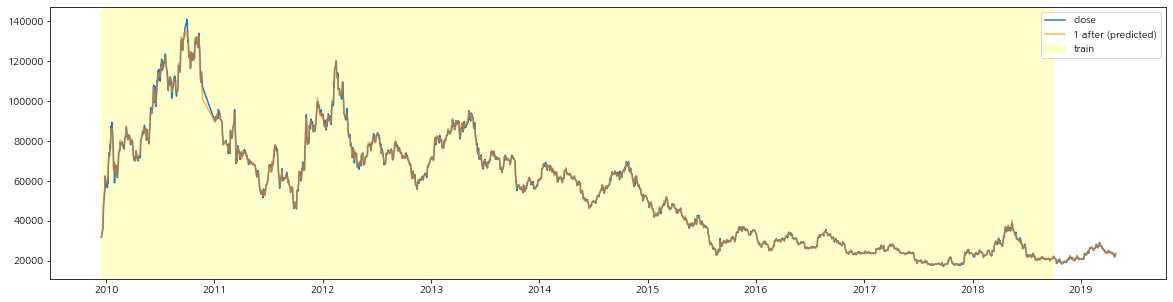

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 195476.92it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4509/4509 [00:00<00:00, 24099.88it/s]


(3796, 3) (142, 3) (3796,) (142,)
0.996525528182871 0.7631466654393182


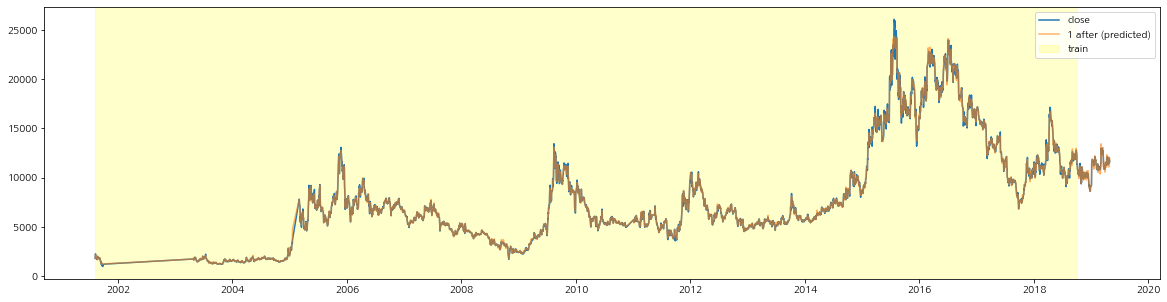

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 216057.74it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4498/4498 [00:00<00:00, 20718.19it/s]


(3785, 3) (142, 3) (3785,) (142,)
0.9916572159962199 -0.49628498989270287


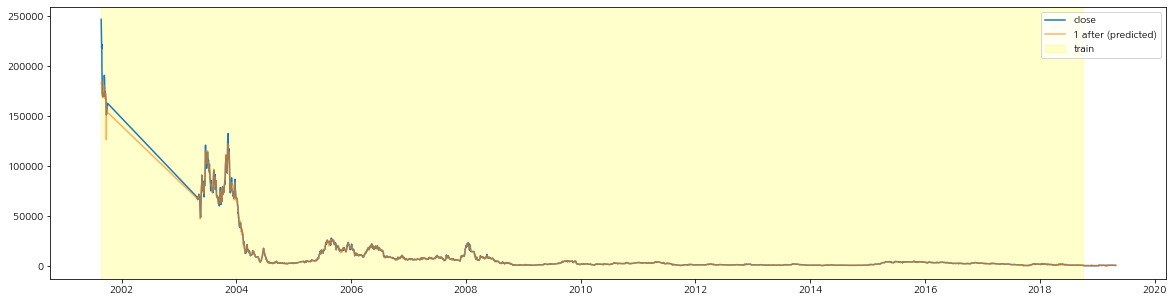

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 140765.20it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4276/4276 [00:00<00:00, 18518.93it/s]


(3757, 3) (142, 3) (3757,) (142,)
0.9968684480175533 0.800027667442111


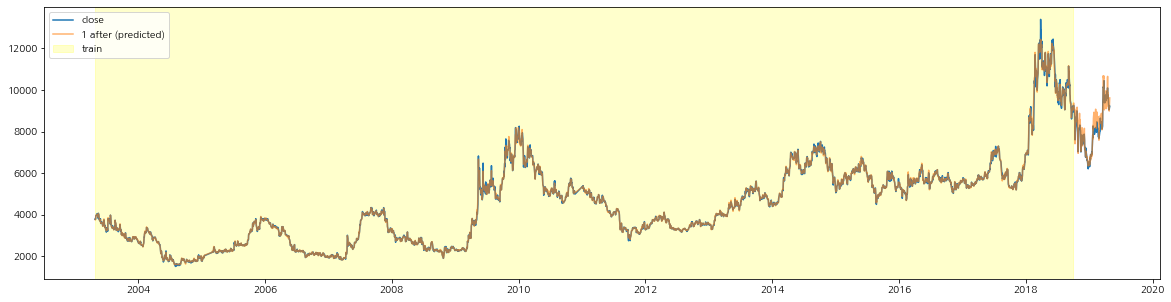

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 201797.70it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4401/4401 [00:00<00:00, 24513.79it/s]


(3757, 3) (142, 3) (3757,) (142,)
0.9953075623211075 0.9599500275039856


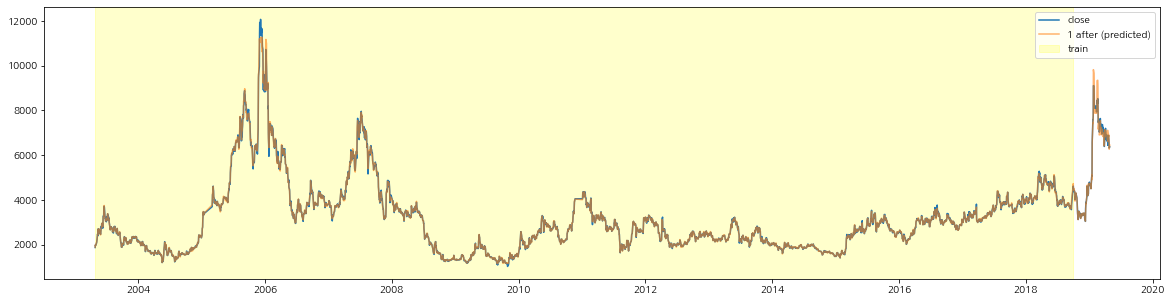

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 183453.52it/s]

100%|███████████████████████████████████████████████████████████████████████████| 3961/3961 [00:00<00:00, 23087.42it/s]


(3632, 3) (142, 3) (3632,) (142,)
0.99807576483264 0.8830772194126317


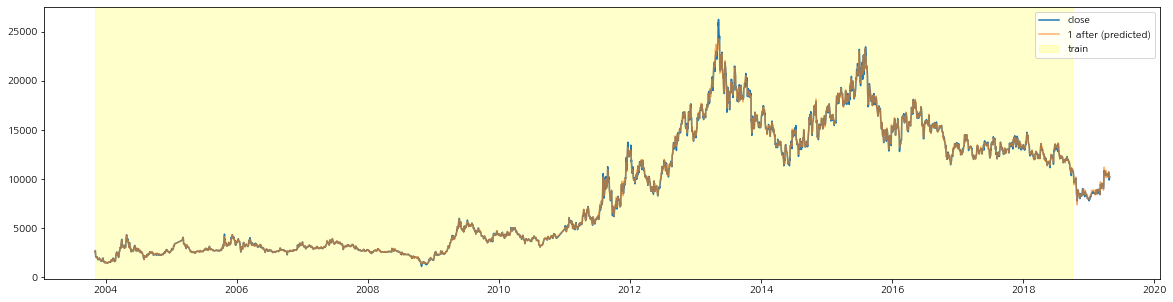

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 155231.28it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4024/4024 [00:00<00:00, 21569.84it/s]


(3695, 3) (142, 3) (3695,) (142,)
0.9890845134090742 0.927228585151359


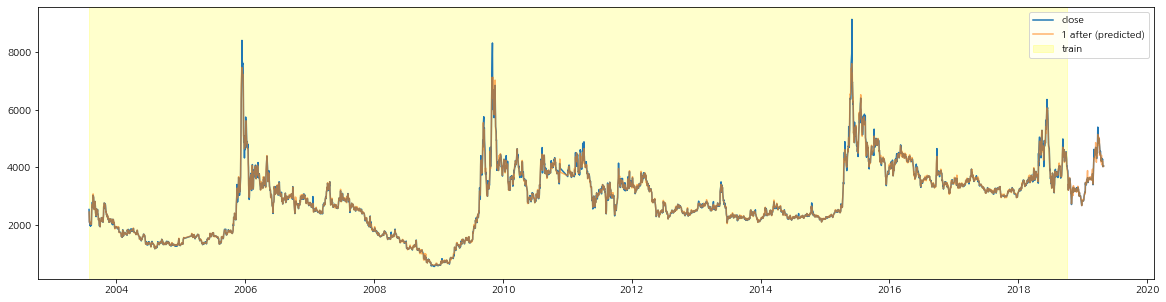

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 201635.42it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4139/4139 [00:00<00:00, 22192.62it/s]


(3757, 3) (142, 3) (3757,) (142,)
0.9932729729057631 0.9752178469286349


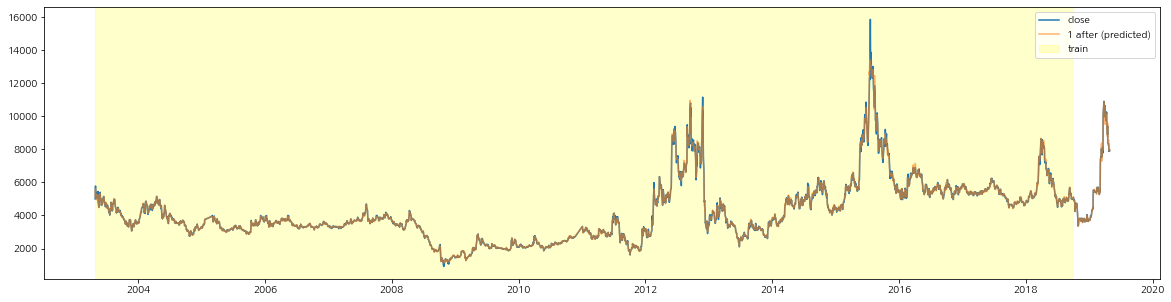

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 168233.56it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4337/4337 [00:00<00:00, 23129.61it/s]


(3757, 3) (142, 3) (3757,) (142,)
0.9944853731549226 0.9038871325338163


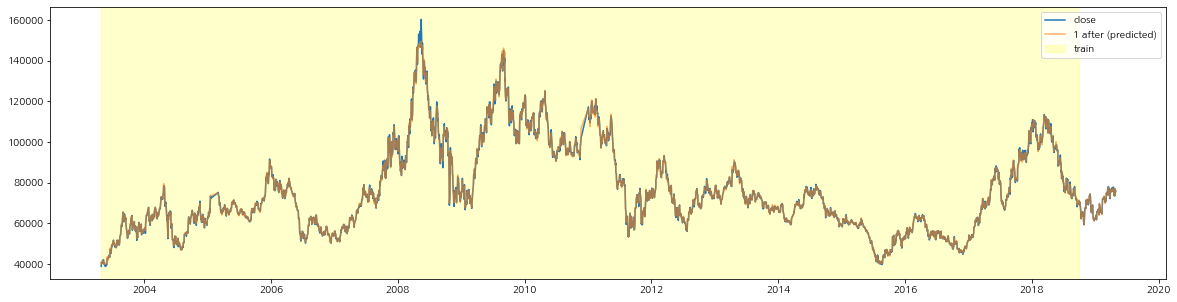

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 216135.18it/s]

100%|███████████████████████████████████████████████████████████████████████████| 4166/4166 [00:00<00:00, 22764.66it/s]


(3757, 3) (142, 3) (3757,) (142,)
0.9983764047672735 0.7546380020400377


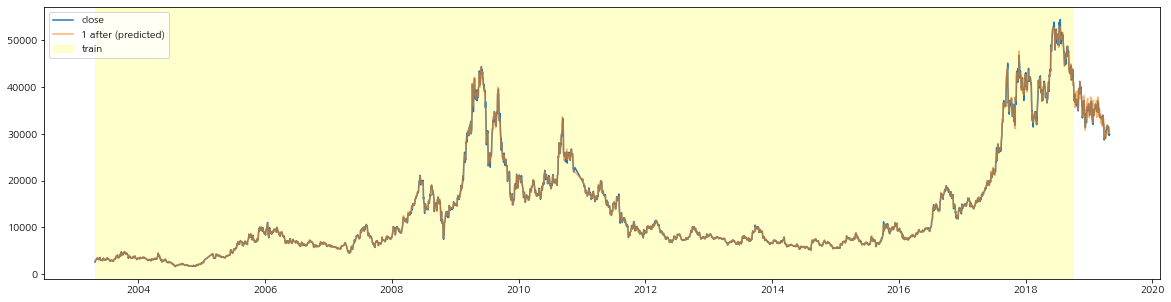

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 183527.97it/s]

100%|███████████████████████████████████████████████████████████████████████████| 3951/3951 [00:00<00:00, 17529.08it/s]


(3622, 3) (142, 3) (3622,) (142,)
0.9974442533431306 0.958473767087536


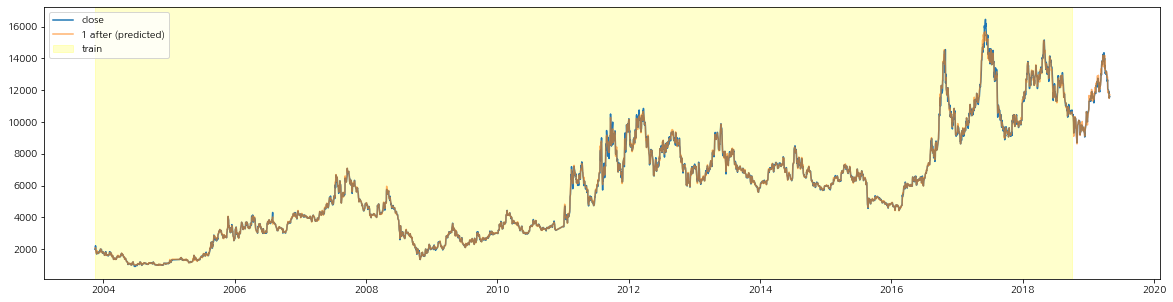

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 195231.29it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2224/2224 [00:00<00:00, 24503.42it/s]


(1926, 3) (142, 3) (1926,) (142,)
0.9850654994249944 0.8270290708116617


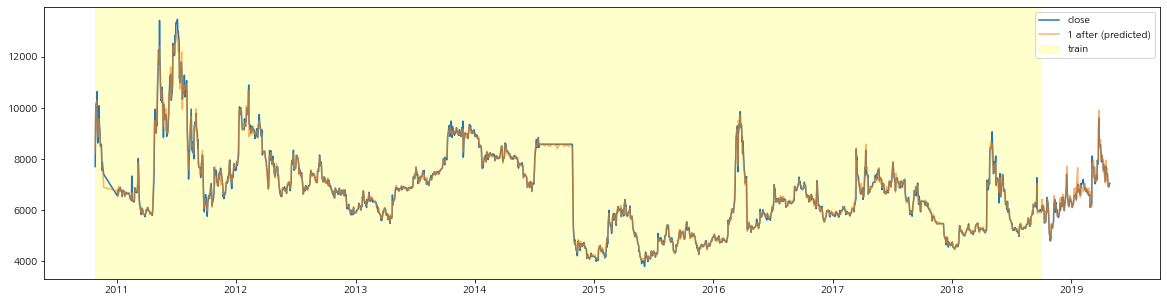

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|███████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 50875.08it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2329/2329 [00:00<00:00, 6948.28it/s]


(2031, 3) (142, 3) (2031,) (142,)
0.9893718305569376 0.8027573896105239


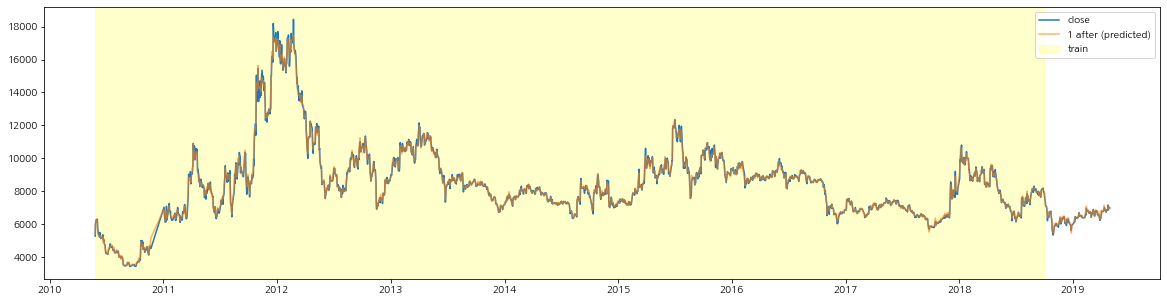

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 201794.48it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2408/2408 [00:00<00:00, 16823.97it/s]


(2110, 3) (142, 3) (2110,) (142,)
0.9930730848547871 0.7806237832675875


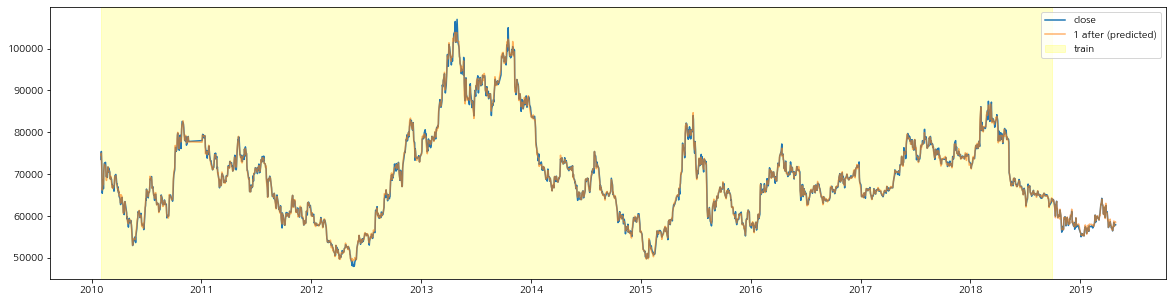

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 189224.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 810/810 [00:00<00:00, 19796.79it/s]


(540, 3) (142, 3) (540,) (142,)
0.982198841960288 0.7482238579532724


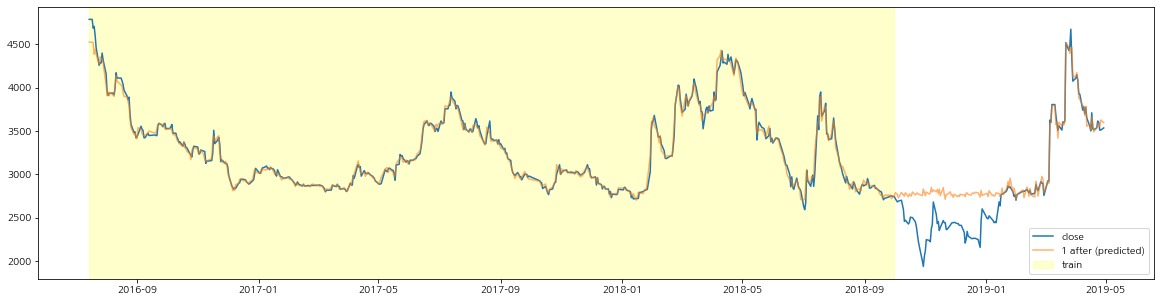

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 201662.72it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2056/2056 [00:00<00:00, 19264.43it/s]


(1786, 3) (142, 3) (1786,) (142,)
0.9917193521024126 0.9248450059036609


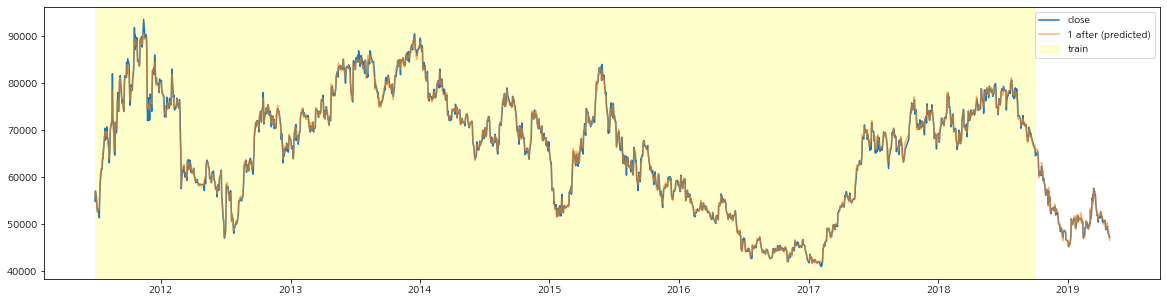

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 201733.40it/s]

100%|███████████████████████████████████████████████████████████████████████████| 3685/3685 [00:00<00:00, 23533.62it/s]


(3357, 3) (142, 3) (3357,) (142,)
0.9977877236925772 0.8177873580107985


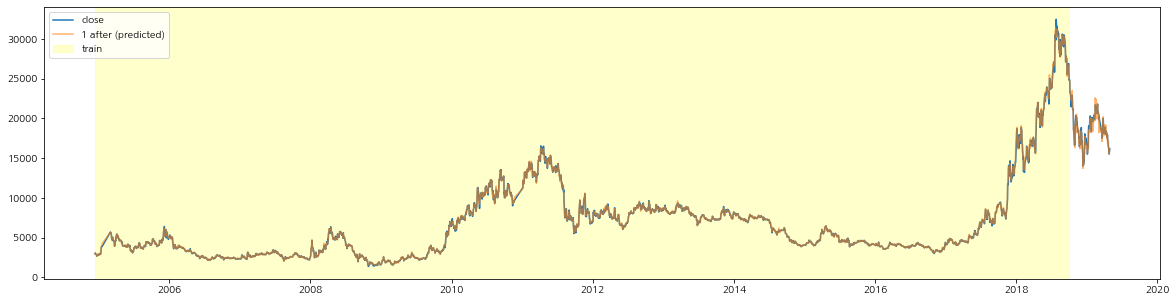

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 178140.79it/s]

100%|███████████████████████████████████████████████████████████████████████████| 3213/3213 [00:00<00:00, 20591.92it/s]


(2914, 3) (142, 3) (2914,) (142,)
0.9958321846927655 0.8913687699544004


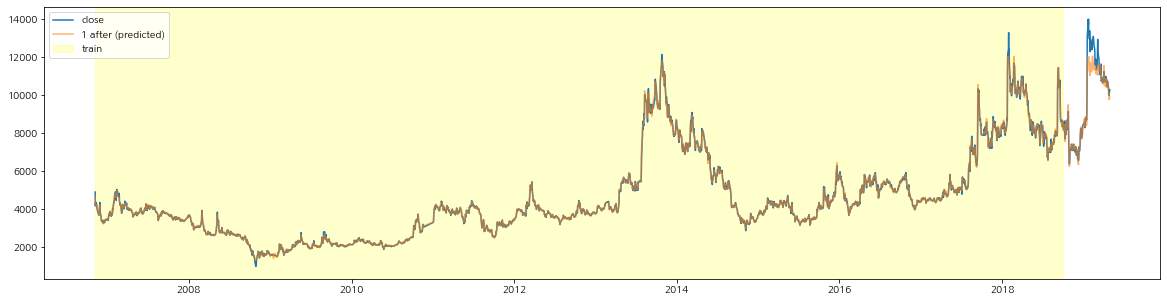

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 189162.07it/s]

100%|███████████████████████████████████████████████████████████████████████████| 3429/3429 [00:00<00:00, 24207.97it/s]


(3127, 3) (142, 3) (3127,) (142,)
0.9963620528175428 0.8941072453581471


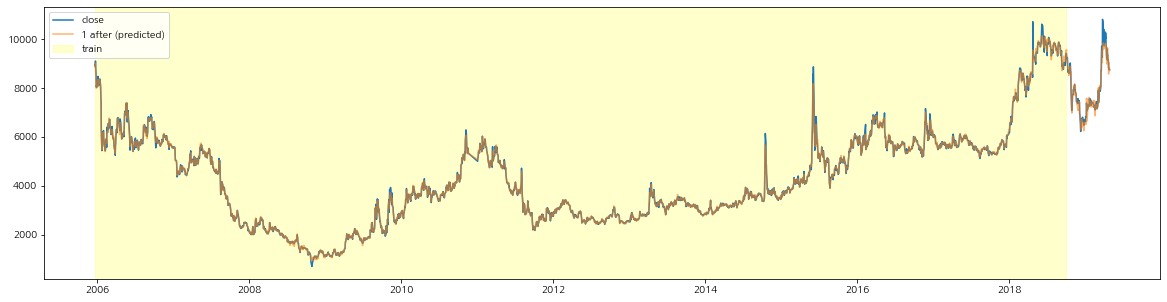

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 224130.77it/s]

100%|███████████████████████████████████████████████████████████████████████████| 3037/3037 [00:00<00:00, 22471.77it/s]


(2738, 3) (142, 3) (2738,) (142,)
0.9980874981057765 0.8886939261300101


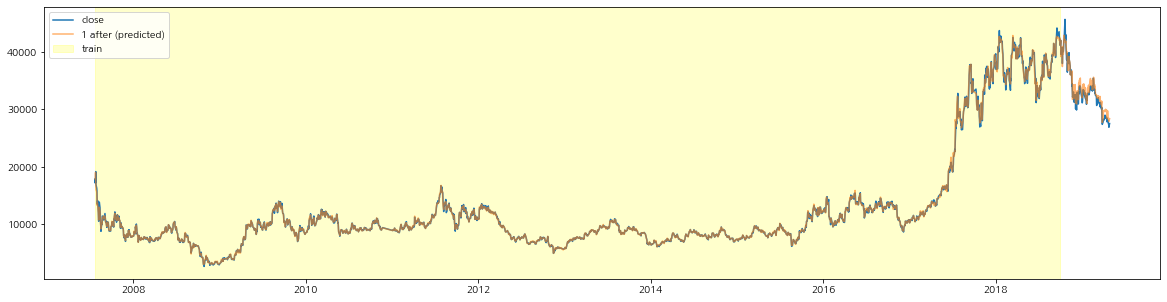

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 208676.66it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2040/2040 [00:00<00:00, 24960.56it/s]


(1770, 3) (142, 3) (1770,) (142,)
0.9974276999798194 0.8830752793153712


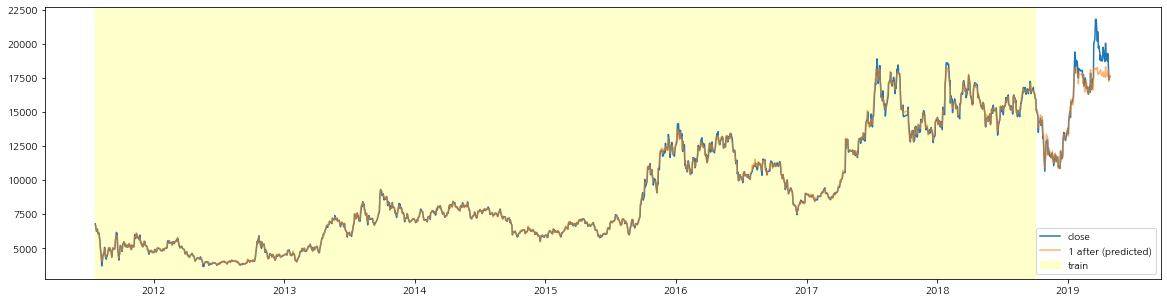

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 163649.22it/s]

100%|███████████████████████████████████████████████████████████████████████████| 3178/3178 [00:00<00:00, 14550.23it/s]


(2879, 3) (142, 3) (2879,) (142,)
0.9962457752522413 0.9134547600225527


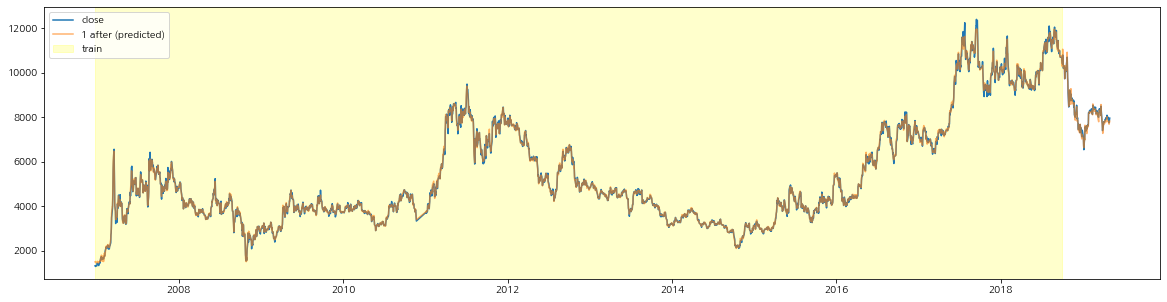

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 216225.60it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2971/2971 [00:00<00:00, 22751.56it/s]


(2672, 3) (142, 3) (2672,) (142,)
0.9922364056853168 0.6878471794600902


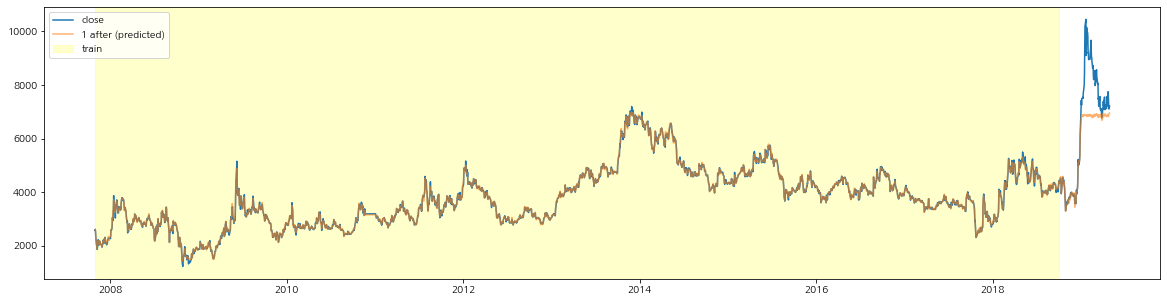

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 112064.89it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2936/2936 [00:00<00:00, 17624.54it/s]


(2637, 3) (142, 3) (2637,) (142,)
0.9943266771814838 0.9418239739581256


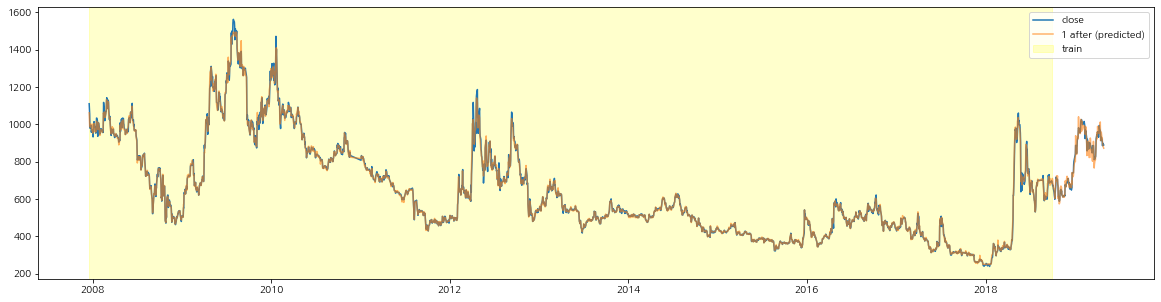

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 195297.53it/s]

100%|███████████████████████████████████████████████████████████████████████████| 3034/3034 [00:00<00:00, 20070.09it/s]


(2735, 3) (142, 3) (2735,) (142,)
0.9941642402155106 0.8749491114328822


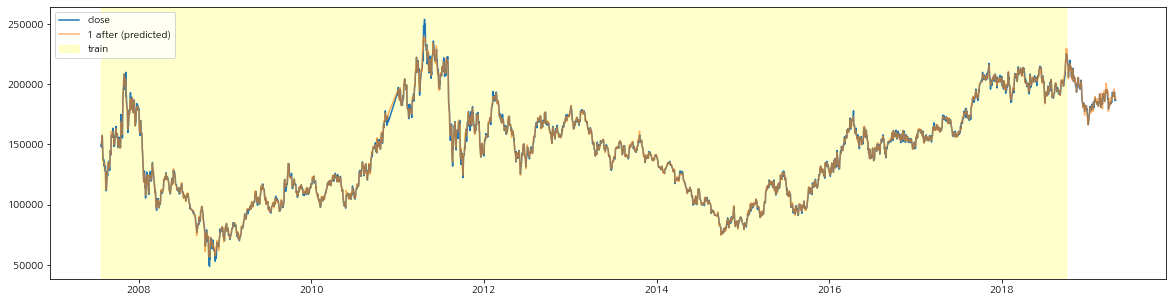

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 195274.94it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2784/2784 [00:00<00:00, 24061.58it/s]


(2485, 3) (142, 3) (2485,) (142,)
0.9903602182550296 0.8845535660784868


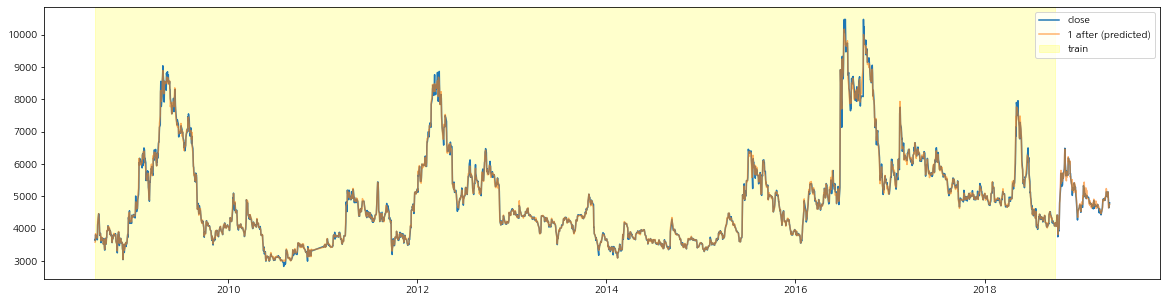

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 189187.51it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2894/2894 [00:00<00:00, 20780.02it/s]


(2595, 3) (142, 3) (2595,) (142,)
0.9934936787987839 -0.40835858588296503


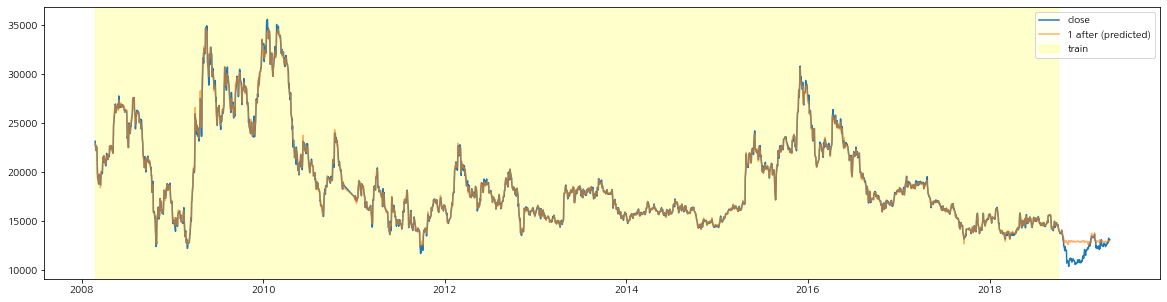

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 183335.32it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2319/2319 [00:00<00:00, 19955.26it/s]


(2021, 3) (142, 3) (2021,) (142,)
0.996824315695052 0.9196179636656594


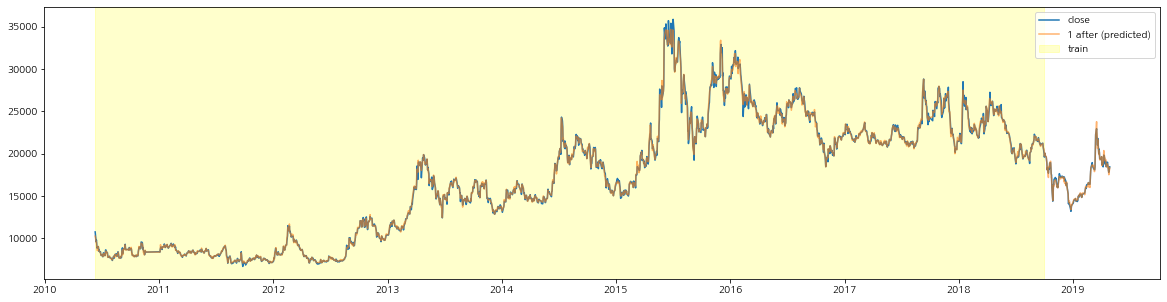

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 178061.88it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2502/2502 [00:00<00:00, 15777.80it/s]


(2203, 3) (142, 3) (2203,) (142,)
0.9983575997135884 0.9055414789540065


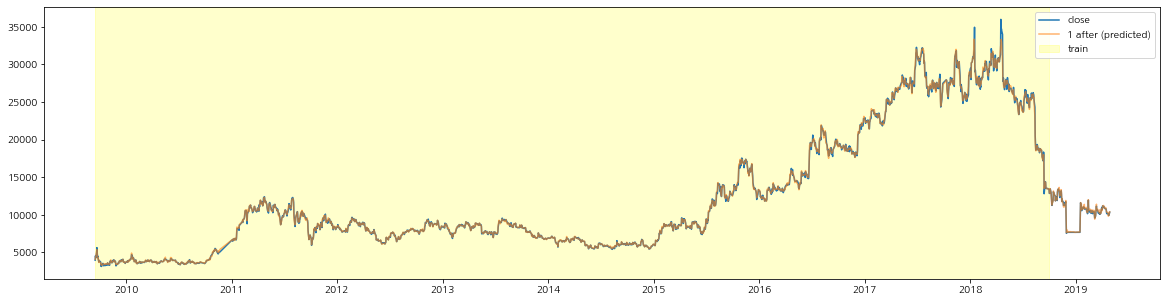

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.


108230.csv


100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 128812.63it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2408/2408 [00:00<00:00, 18290.60it/s]


(2110, 3) (142, 3) (2110,) (142,)
0.9954570309485642 0.9649594521552673


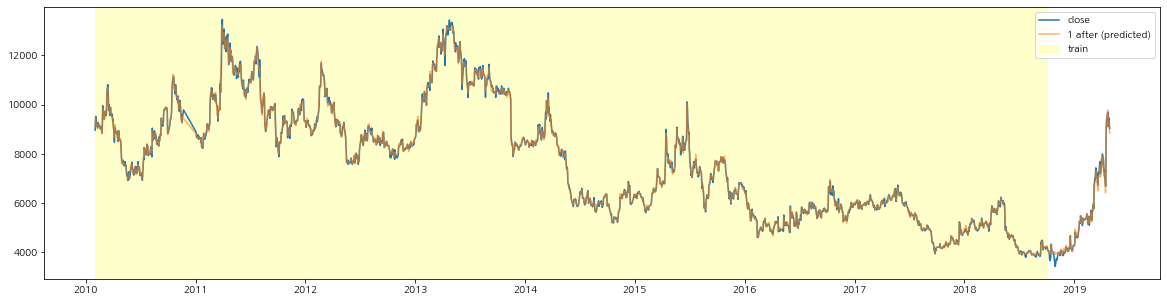

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 126127.83it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2156/2156 [00:00<00:00, 17362.65it/s]


(1886, 3) (142, 3) (1886,) (142,)
0.9971078857293453 0.9727060013718419


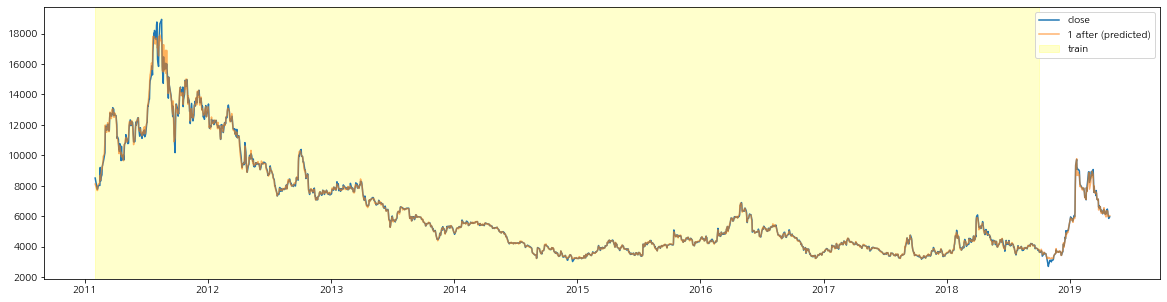

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 208767.83it/s]

100%|███████████████████████████████████████████████████████████████████████████| 2196/2196 [00:00<00:00, 21188.37it/s]


(1906, 3) (142, 3) (1906,) (142,)
0.9974418151969301 0.8505380360240746


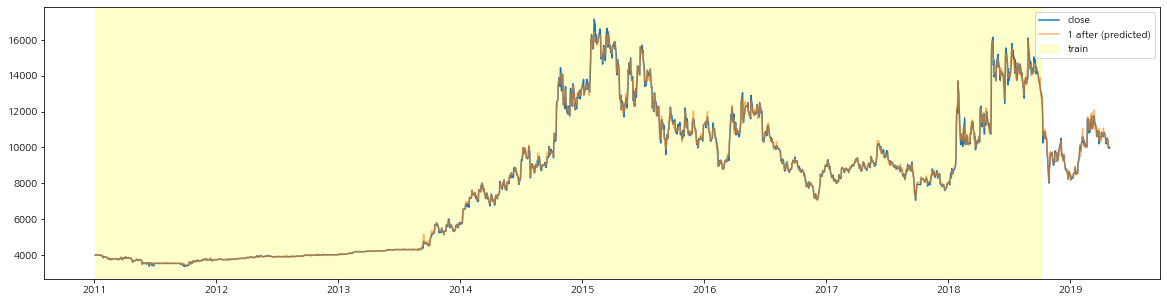

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 195329.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 22115.62it/s]


(414, 3) (142, 3) (414,) (142,)
0.9719231818081485 0.7697618313254143


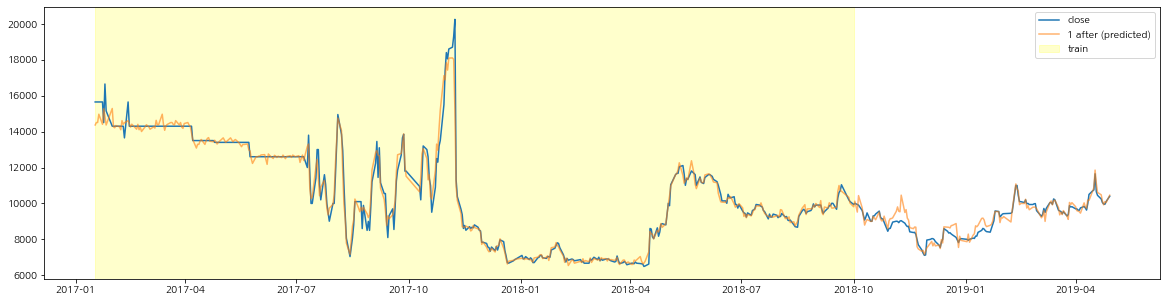

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 183454.85it/s]

100%|███████████████████████████████████████████████████████████████████████████| 1348/1348 [00:00<00:00, 18265.27it/s]


(1078, 3) (142, 3) (1078,) (142,)
0.9940193803635945 0.9162916050715794


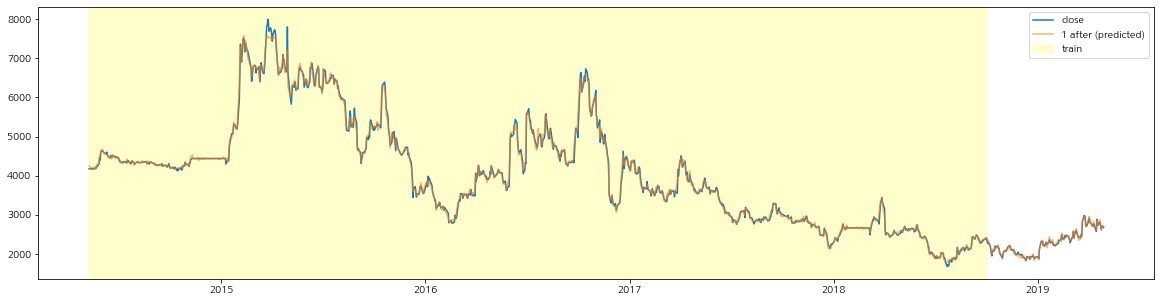

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 159337.16it/s]

100%|███████████████████████████████████████████████████████████████████████████| 1286/1286 [00:00<00:00, 21490.40it/s]


(1016, 3) (142, 3) (1016,) (142,)
0.9950460547422296 0.8743075291041285


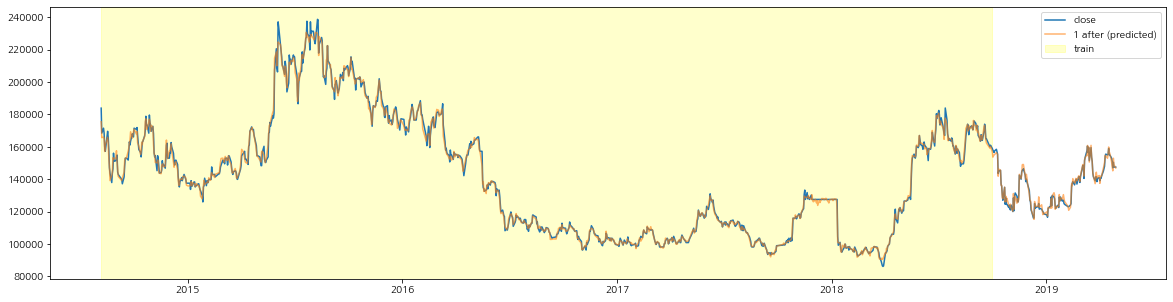

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 172975.76it/s]

100%|███████████████████████████████████████████████████████████████████████████| 1022/1022 [00:00<00:00, 20912.38it/s]


(752, 3) (142, 3) (752,) (142,)
0.9882193471926597 0.8298668425163648


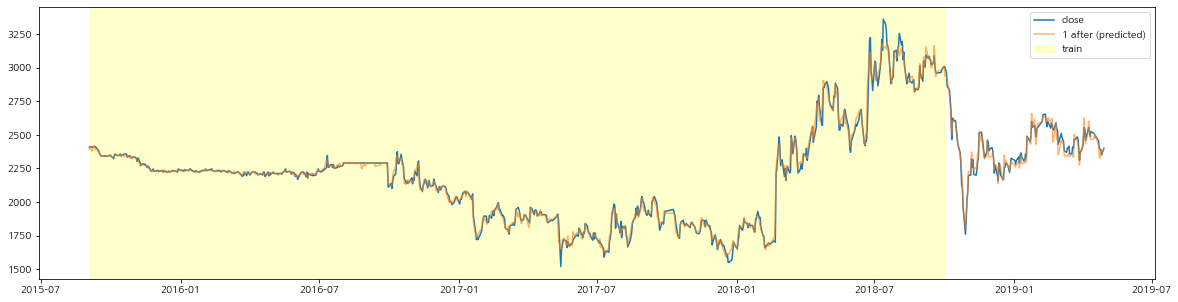

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 163632.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 838/838 [00:00<00:00, 22710.59it/s]


(568, 3) (142, 3) (568,) (142,)
0.9970153378802648 0.7413016785350067


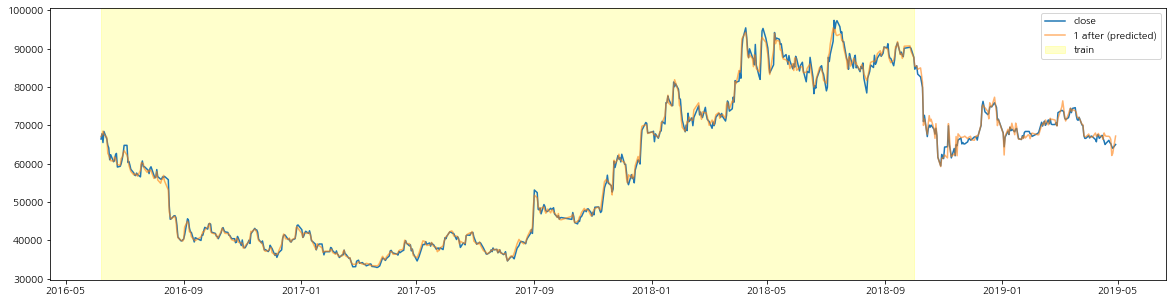

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 163630.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 22259.46it/s]


(174, 3) (142, 3) (174,) (142,)
0.94309822452325 0.7185639013833982


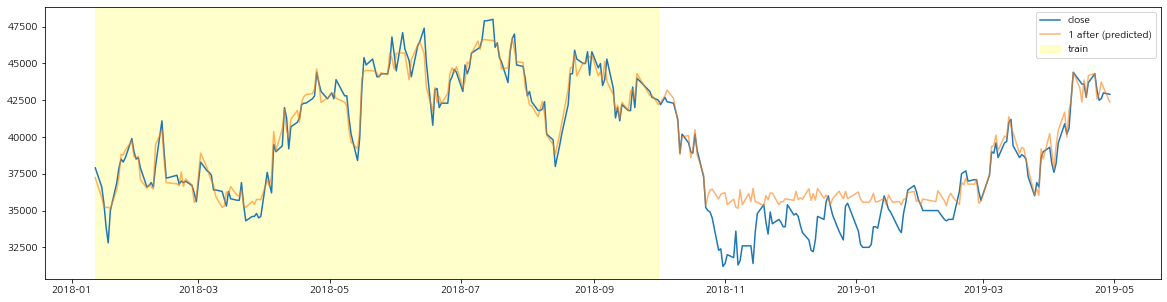

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 195312.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 18689.41it/s]


(0, 3) (133, 3) (0,) (133,)
288620.csv


100%|██████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 216173.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 16091.64it/s]


(51, 3) (142, 3) (51,) (142,)
0.7400640414290114 -3.768329336300857


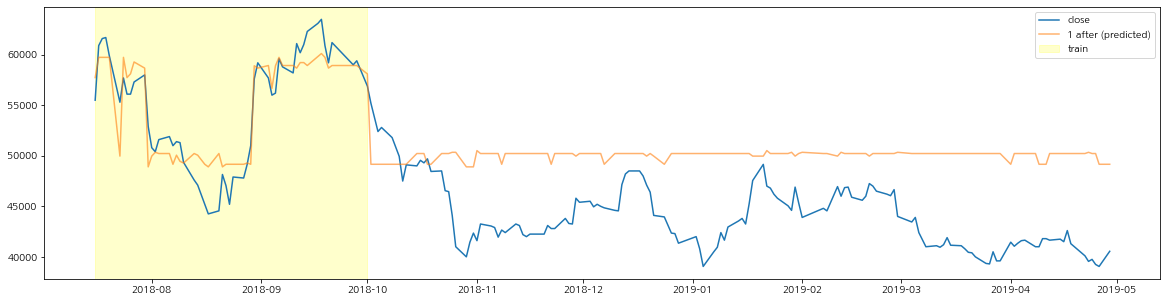

C:\Users\remig\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Data index is not datetime. Assuming simple periods.
 99%|████████████████████████████████████████████████████████████████████████████████▉ | 78/79 [01:23<00:00,  1.95it/s]

Social.docx


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:23<00:00,  1.05s/it]


In [32]:
for i in tqdm(range(len(files))):
    try: 
        auto(i)
    except:
        print(list_col[i])
        pass

In [33]:
df3

000520.csv 000250.csv 000640.csv 001060.csv  \
Start                            0          0          0          0   
End                            141        141        141        141   
Duration                       141        141        141        141   
Exposure [%]               80.8511    80.8511    80.8511    80.8511   
Equity Final [$]           9410.18    7323.61    10456.4       8741   
Equity Peak [$]            10044.1    10727.8      10806    10177.6   
Return [%]                 -5.8982   -26.7639     4.5644     -12.59   
Buy & Hold Return [%]      10.7095   0.431034          0    12.7873   
Max. Drawdown [%]         -37.3239   -50.6544   -14.4877   -24.2789   
Avg. Drawdown [%]          -26.164    -10.636   -4.70981        NaN   
Max. Drawdown Duration          88         43         73        NaN   
Avg. Drawdown Duration          88         16    15.8333        NaN   
# Trades                        15         15         15         15   
Win Rate [%]                    40    46.6667    46.6667         40   
Best Trade [%]             27.7273    12.3746    8.77193    10.0119   
Worst Trade [%]           -18.3295   -44.8373   -5.71429   -6.56923   
Avg. Trade [%]           -0.200599  -0.913262   0.397242  -0.668477   
Max. Trade Duration             19         19         19         19   
Avg. Trade Duration            7.6        7.6        7.6        7.6   
Expectancy [%]             6.67333    8.87824    3.40372    2.92962   
SQN                      -0.238222  -0.523153   0.355369  -0.797105   
Sharpe Ratio            -0.0191491 -0.0643148  0.0973764  -0.163903   
Sortino Ratio           -0.0327162 -0.0603392   0.287964  -0.274255   
Calmar Ratio           -0.00537453 -0.0180293  0.0274193 -0.0275333   
_strategy                 SmaCross   SmaCross   SmaCross   SmaCross   

                       001540.csv 001820.csv 002700.csv 002720.csv 003850.csv  \
Start                           0          0          0          0          0   
End                           141        141        141        141        141   
Duration                      141        141        141        141        141   
Exposure [%]              80.8511    80.8511    80.8511    80.8511    80.8511   
Equity Final [$]          11523.1    5403.88    8878.09    6921.93       8107   
Equity Peak [$]           12937.4    10442.9    10563.8    10165.7      10000   
Return [%]                15.2314   -45.9612   -11.2191   -30.7807     -18.93   
Buy & Hold Return [%]      8.7108    17.2753    48.6891    6.92168    17.9825   
Max. Drawdown [%]        -19.7637   -48.2532   -25.0696   -33.2416   -30.5339   
Avg. Drawdown [%]        -6.85243        NaN   -8.84033   -18.2911        NaN   
Max. Drawdown Duration         44        NaN         53         97        NaN   
Avg. Drawdown Duration       16.4        NaN         29         97        NaN   
# Trades                       15         15         15         15         15   
Win Rate [%]                   40    33.3333    46.6667         40    26.6667   
Best Trade [%]            22.4299     12.766    16.2791    6.83479    9.27273   
Worst Trade [%]          -10.1449   -15.4976   -16.7131   -16.1885   -12.1951   
Avg. Trade [%]             1.1963    -2.9697  -0.510123   -1.86815   -1.57477   
Max. Trade Duration            19         19         19         19         19   
Avg. Trade Duration           7.6        7.6        7.6        7.6        7.6   
Expectancy [%]            5.71511    7.13225    4.85938    4.90879    5.15963   
SQN                      0.466771   -1.53103  -0.392846   -1.10665   -1.23762   
Sharpe Ratio             0.151812  -0.347588 -0.0697059  -0.283627    -0.2883   
Sortino Ratio            0.384133  -0.524563 -0.0890966  -0.327213  -0.492041   
Calmar Ratio            0.0605299  -0.061544 -0.0203482 -0.0561991 -0.0515744   
_strategy                SmaCross   SmaCross   SmaCross   SmaCross   SmaCross   

                       004690.csv  ... 119650.csv 126880.csv 131030.cs

In [34]:
df3.to_csv('C:\\Users\\remig\\Desktop\\df3.csv')

In [35]:
df3.columns

Index(['000520.csv', '000250.csv', '000640.csv', '001060.csv', '001540.csv',
       '001820.csv', '002700.csv', '002720.csv', '003850.csv', '004690.csv',
       '005070.csv', '006400.csv', '007610.csv', '007720.csv', '009440.csv',
       '009520.csv', '011230.csv', '011320.csv', '012340.csv', '012690.csv',
       '016920.csv', '020150.csv', '021240.csv', '022100.csv', '032680.csv',
       '033500.csv', '033530.csv', '034020.csv', '034940.csv', '036460.csv',
       '036830.csv', '042040.csv', '043100.csv', '043260.csv', '044340.csv',
       '045060.csv', '045520.csv', '051910.csv', '052690.csv', '053030.csv',
       '053590.csv', '058610.csv', '059090.csv', '065510.csv', '065950.csv',
       '066130.csv', '066570.csv', '066970.csv', '067170.csv', '069140.csv',
       '071200.csv', '071320.csv', '071460.csv', '071840.csv', '078600.csv',
       '080470.csv', '083550.csv', '086520.csv', '089980.csv', '093370.csv',
       '095190.csv', '096350.csv', '096770.csv', '100090.csv', '100840.csv',

In [36]:
# 알수없는 오류로 처리되지 않은 파일 

list(set(list_col)-set(df3.columns))

['288620.csv', '108230.csv', 'Social.docx']